### Analysis and plotting

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import os

# for plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

# for plotting ASTER geotiffs
import rasterio as rio
import rasterio.plot as rioplt

# for shapefile
import geopandas as gpd

# for calculating zonal statistics
import aster_utils

import warnings
warnings.filterwarnings('ignore')

In [2]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    # https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles 

Set font sizes for plots

In [3]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

---
## Open data files

---
---
#### Open our merged GOES-CUES dataset

In [4]:
cues_ds = pd.read_pickle('goes-cues_2017-2020.pkl')
cues_ds = cues_ds.to_xarray()

Load MODIS observations of the CUES site

In [5]:
#modis_1 = pd.read_pickle('./MODIS_data/cues_2017_1-59.pkl')
#modis_2 = pd.read_pickle('./MODIS_data/cues_2017_60-120.pkl')
#
## Concatenate the two MODIS time series together
#modis = pd.concat([modis_1, modis_2], ignore_index=True)

When do we have ASTER observations of this site?

In [6]:
# Find all our ASTER files for the CUES site
directory = r"//j-lundquist-3.ce.washington.edu/storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES"
aster_files = getListOfFiles(directory)

## Parse the date and time from ASTER filenames
aster_datetimes = []
aster_datetimes_UTC = []
for fpath in aster_files:
    fn = fpath.split('\\')[-1] # non-re method
    MM = fn.split('_')[2][3:5]
    DD = fn.split('_')[2][5:7]
    YYYY = fn.split('_')[2][7:11]
    hh = fn.split('_')[2][11:13]
    mm = fn.split('_')[2][13:15]
    ss = fn.split('_')[2][15:17]
    aster_datetimes_UTC.append(pd.Timestamp('{}-{}-{} {}:{}:{}'.format(YYYY, MM, DD, hh, mm, ss),tz='UTC'))
    aster_datetimes.append(pd.Timestamp('{}-{}-{} {}:{}:{}'.format(YYYY, MM, DD, hh, mm, ss),tz='UTC')- pd.Timedelta(8, unit='hours'))

aster = pd.DataFrame({'datetime': aster_datetimes, 'datetimeUTC': aster_datetimes_UTC, 'filepath': aster_files})
aster.sort_values('datetime',inplace=True)
aster.reset_index(inplace=True, drop=True)

In [7]:
aster

datetime               datetimeUTC  \
0  2017-03-04 10:51:03+00:00 2017-03-04 18:51:03+00:00   
1  2017-03-20 10:51:06+00:00 2017-03-20 18:51:06+00:00   
2  2017-04-21 10:51:07+00:00 2017-04-21 18:51:07+00:00   
3  2017-05-23 10:51:10+00:00 2017-05-23 18:51:10+00:00   
4  2017-06-06 22:07:10+00:00 2017-06-07 06:07:10+00:00   
5  2017-06-06 22:07:19+00:00 2017-06-07 06:07:19+00:00   
6  2017-06-15 22:01:08+00:00 2017-06-16 06:01:08+00:00   
7  2017-09-21 10:45:30+00:00 2017-09-21 18:45:30+00:00   
8  2017-11-06 22:01:15+00:00 2017-11-07 06:01:15+00:00   
9  2017-11-29 22:07:13+00:00 2017-11-30 06:07:13+00:00   
10 2017-11-29 22:07:22+00:00 2017-11-30 06:07:22+00:00   
11 2018-01-02 21:54:58+00:00 2018-01-03 05:54:58+00:00   
12 2018-03-23 10:51:27+00:00 2018-03-23 18:51:27+00:00   
13 2018-04-08 10:51:46+00:00 2018-04-08 18:51:46+00:00   
14 2018-05-17 10:58:31+00:00 2018-05-17 18:58:31+00:00   
15 2018-05-26 10:52:25+00:00 2018-05-26 18:52:25+00:00   
16 2018-06-02 10:58:39+00:00 2018-06-02 18:58:39+00:00   
17 2018-06-02 22:02:25+00:00 2018-06-03 06:02:25+00:00   
18 2018-06-04 10:46:27+00:00 2018-06-04 18:46:27+00:00   
19 2018-10-10 10:46:03+00:00 2018-10-10 18:46:03+00:00   
20 2018-10-17 10:52:00+00:00 2018-10-17 18:52:00+00:00   
21 2018-10-31 22:07:55+00:00 2018-11-01 06:07:55+00:00   
22 2018-11-25 22:01:19+00:00 2018-11-26 06:01:19+00:00   
23 2018-12-18 22:07:13+00:00 2018-12-19 06:07:13+00:00   
24 2018-12-18 22:07:22+00:00 2018-12-19 06:07:22+00:00   
25 2019-01-12 22:01:10+00:00 2019-01-13 06:01:10+00:00   
26 2019-03-26 10:51:20+00:00 2019-03-26 18:51:20+00:00   
27 2019-04-27 10:51:22+00:00 2019-04-27 18:51:22+00:00   
28 2019-05-13 10:51:22+00:00 2019-05-13 18:51:22+00:00   
29 2019-05-27 22:07:18+00:00 2019-05-28 06:07:18+00:00   
30 2019-05-27 22:07:27+00:00 2019-05-28 06:07:27+00:00   
31 2019-05-29 10:51:19+00:00 2019-05-29 18:51:19+00:00   
32 2019-06-05 22:01:13+00:00 2019-06-06 06:01:13+00:00   
33 2019-06-12 22:07:13+00:00 2019-06-13 06:07:13+00:00   
34 2019-06-12 22:07:22+00:00 2019-06-13 06:07:22+00:00   
35 2019-06-30 10:51:06+00:00 2019-06-30 18:51:06+00:00   
36 2019-06-30 21:54:52+00:00 2019-07-01 05:54:52+00:00   
37 2019-07-07 22:01:01+00:00 2019-07-08 06:01:01+00:00   
38 2019-08-01 10:51:02+00:00 2019-08-01 18:51:02+00:00   
39 2019-10-04 10:50:49+00:00 2019-10-04 18:50:49+00:00   
40 2019-11-12 22:00:42+00:00 2019-11-13 06:00:42+00:00   
41 2019-12-30 22:00:40+00:00 2019-12-31 06:00:40+00:00   
42 2020-01-06 22:06:41+00:00 2020-01-07 06:06:41+00:00   
43 2020-01-06 22:06:50+00:00 2020-01-07 06:06:50+00:00   
44 2020-01-22 22:06:58+00:00 2020-01-23 06:06:58+00:00   
45 2020-01-22 22:07:07+00:00 2020-01-23 06:07:07+00:00   
46 2020-01-31 22:01:09+00:00 2020-02-01 06:01:09+00:00   
47 2020-02-07 22:07:29+00:00 2020-02-08 06:07:29+00:00   
48 2020-02-25 21:55:25+00:00 2020-02-26 05:55:25+00:00   
49 2020-03-05 10:45:35+00:00 2020-03-05 18:45:35+00:00   
50 2020-04-13 10:51:17+00:00 2020-04-13 18:51:17+00:00   
51 2020-04-29 10:51:04+00:00 2020-04-29 18:51:04+00:00   
52 2020-05-15 10:51:04+00:00 2020-05-15 18:51:04+00:00   
53 2020-06-14 22:07:00+00:00 2020-06-15 06:07:00+00:00   
54 2020-06-16 10:51:01+00:00 2020-06-16 18:51:01+00:00   
55 2020-06-16 21:54:47+00:00 2020-06-17 05:54:47+00:00   

                                             filepath  
0   //j-lundquist-3.ce.washington.edu/storage/spes...  
1   //j-lundquist-3.ce.washington.edu/storage/spes...  
2   //j-lundquist-3.ce.washington.edu/storage/spes...  
3   //j-lundquist-3.ce.washington.edu/storage/spes...  
4   //j-lundquist-3.ce.washington.edu/storage/spes...  
5   //j-lundquist-3.ce.washington.edu/storage/spes...  
6   //j-lundquist-3.ce.washington.edu/storage/spes...  
7   //j-lundquist-3.ce.washington.edu/storage/spes...  
8   //j-lundquist-3.ce.washington.edu/storage/spes...  
9   //j-lundquist-3.ce.washington.edu/storage/spes...  
10  //j-lundquist-3.ce.washington.edu/storage/spes...  
11  //j-lundquist-3.ce.washington.edu/sto

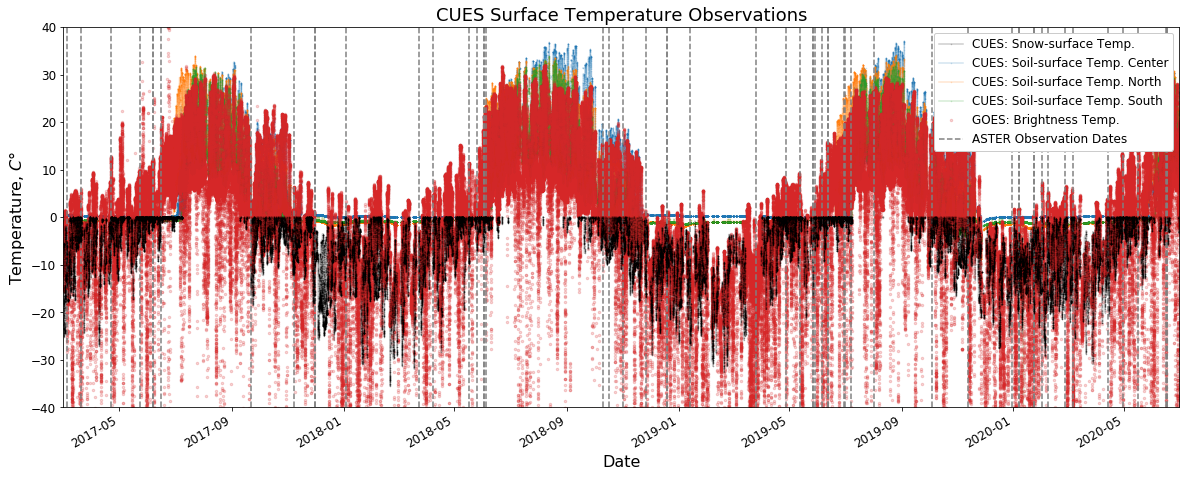

In [8]:
# Set start and end dates for time period we want to look at
startdate = cues_ds.datetime.min().values
enddate = cues_ds.datetime.max().values
#startdate = pd.Timestamp('2017-03-20')
#enddate = pd.Timestamp('2017-03-21')

alpha = 0.2
condition = cues_ds.cloud_flag==0

# Set up figure
fig, ax = plt.subplots(figsize=(20,7))

# Plot CUES snow surface temperature
cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].where(condition).plot(
    c='k', marker='.', ax=ax, markersize=1, linestyle='-', zorder=99, alpha=alpha)

# Plot CUES soil surface temperature
cues_ds['soil temperature @ 0cm; soil temp at 0cm  center; (degrees Celsius)'].where(condition).plot(ax=ax, linestyle='-', marker='.', markersize=1, alpha=alpha)
cues_ds['soil temp at 0cm  north; soil thermistor at 0cm  north; (deg C)'].where(condition).plot(ax=ax, linestyle='-', marker='.', markersize=1, alpha=alpha)
cues_ds['soil temp at 0cm  south; soil thermistor at 0cm  south; (deg C)'].where(condition).plot(ax=ax, linestyle='-', marker='.', markersize=1, alpha=alpha)

# Plot GOES brightness temperature
cues_ds.goes_tb_c.where(condition).plot(c='tab:red', linestyle='none', marker='.', markersize=5, ax=ax, alpha=alpha)

# Plot when we have ASTER observations of the CUES site
for aster_datetime in aster.datetime:
    plt.axvline(x=aster_datetime, color='grey', linestyle='--')

ax.set_xlim([startdate,enddate])
ax.set_ylim([-40,40])
ax.set_ylabel('Temperature, $C\degree$')
ax.set_xlabel('Date')

# Make legend
lines = [ax.lines[0], ax.lines[1], ax.lines[2], ax.lines[3], ax.lines[4], ax.lines[5]]
labels = ['CUES: Snow-surface Temp.', 
          'CUES: Soil-surface Temp. Center', 
          'CUES: Soil-surface Temp. North', 
          'CUES: Soil-surface Temp. South',
          'GOES: Brightness Temp.',
         'ASTER Observation Dates']
ax.legend(lines, labels, loc='upper right', facecolor='white', framealpha=1)

# Set title
plt.title('CUES Surface Temperature Observations');



# Save figure image
#plt.savefig('goes-cues-Mar2017-Jun2020.jpg',dip=300);

## For comparison with ASTER

Look at all of our ASTER observations on a timeline

to do:
* calculate zonal statistics for each

In [9]:
#aster_subset = aster.loc[[0,5,10,15,20,25,31,35]]
#aster_subset.reset_index(inplace=True)

In [10]:
aster_subset = aster

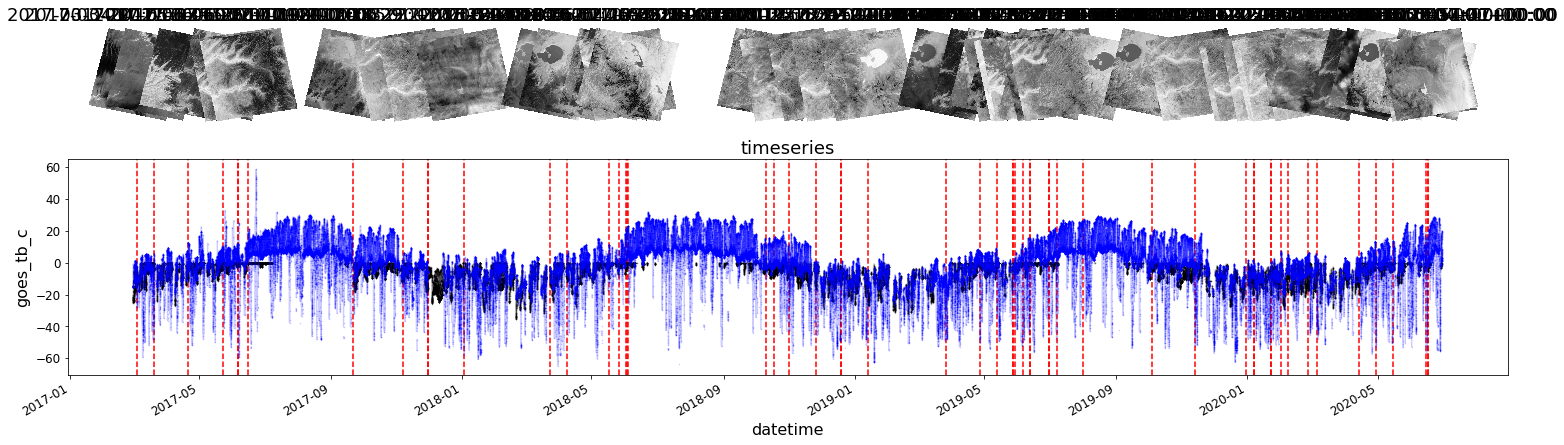

In [11]:
n_total = aster_subset.shape[0]

fig, ax = plt.subplots(figsize=(20,5))

# Plot CUES snow surface temperature
cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].where(condition).plot(
    c='k', marker='.', ax=ax, markersize=1, linestyle='-', zorder=99, alpha=alpha)
# Plot GOES brightness temp timeseries
cues_ds.goes_tb_c.where(condition).plot(
    c='b', marker='.', ax=ax, markersize=1, linestyle='-', zorder=99, alpha=alpha)
ax.set_position([0, 0, 1, 0.6])
ax.set_title('timeseries')



for n in range(n_total):

    # draw a vertical line at the ASTER observation date
    ax.axvline(aster_subset.datetime[n], c='r', linestyle='--')
    
    # Inset plot
    inset_plot_width = 0.25 + 1/n_total
    inset_plot_height = 0.25 + 1/n_total
    
    
    # transform from data coordinates (x=datetime64, y=temperature) into display coordinates (pixels)
    xdisplay, ydisplay = ax.transData.transform((mdates.date2num(aster_subset.datetime[n]),0))
    # create an inverse transform from display coordinates (pixels) into figure coordinates (fractions)
    inv = fig.transFigure.inverted()
    # apply the inverse transform
    inset_plot_xpos, _ = inv.transform((xdisplay, ydisplay))
    
    #inset_plot_xpos = np.linspace(0, 1-(1/n_total), n_total)[n] # x coordinate for evenly spaced images
    inset_plot_ypos = 0.7 # fixed y coordinate
    
    current_ax = fig.add_axes([inset_plot_xpos - (inset_plot_width/2), inset_plot_ypos, 
                               inset_plot_width, inset_plot_height], 
                              facecolor='k')
    current_ax.set_title('{}'.format(aster_subset.datetime[n]))
    current_ax.axis('off')
    
    fpath = os.path.normpath(aster_subset.filepath[n])
    with rio.open(fpath) as src:
        a = src.read(1)
        a = a.astype('float32')
        a[a==0] = np.nan
        current_ax.imshow(a, cmap='Greys_r')



### For each day we're interested in with an ASTER observation:

Create 1-to-1 plots to take a look in more detail for days with ASTER observations

I'm including all data points here (not filtering out cloudy periods)

* plot GOES Tb vs CUES Tss
* highlight the point when ASTER flew over

Got 'NoneType' object is not iterable for ASTER at 2017-06-06 22:07:10+00:00
(likely that the shapefile doesn't intersect the ASTER image)
Got 'NoneType' object is not iterable for ASTER at 2017-09-21 10:45:30+00:00
(likely that the shapefile doesn't intersect the ASTER image)
Got 'NoneType' object is not iterable for ASTER at 2017-11-29 22:07:13+00:00
(likely that the shapefile doesn't intersect the ASTER image)
Got 'NoneType' object is not iterable for ASTER at 2018-01-02 21:54:58+00:00
(likely that the shapefile doesn't intersect the ASTER image)
Got 'NoneType' object is not iterable for ASTER at 2018-03-23 10:51:27+00:00
(likely that the shapefile doesn't intersect the ASTER image)
Got 'NoneType' object is not iterable for ASTER at 2018-04-08 10:51:46+00:00
(likely that the shapefile doesn't intersect the ASTER image)
Got 'NoneType' object is not iterable for ASTER at 2018-06-04 10:46:27+00:00
(likely that the shapefile doesn't intersect the ASTER image)
Got 'NoneType' object is no

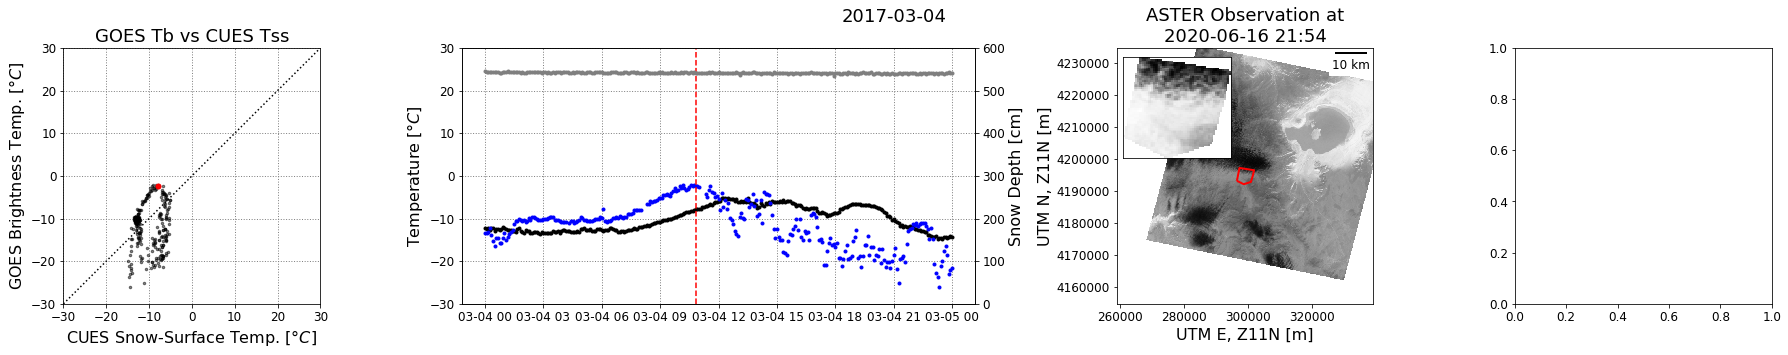

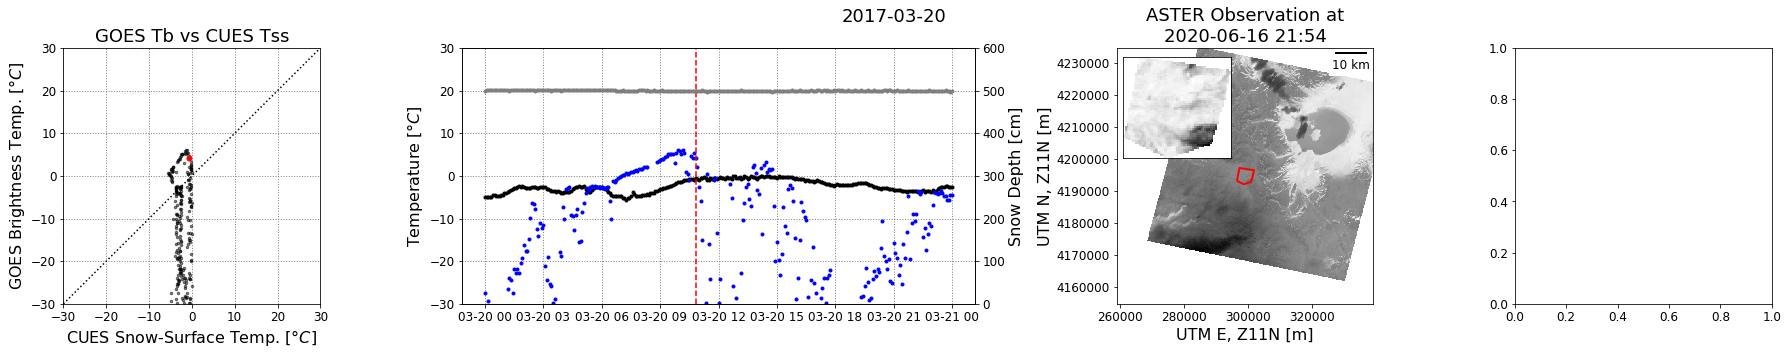

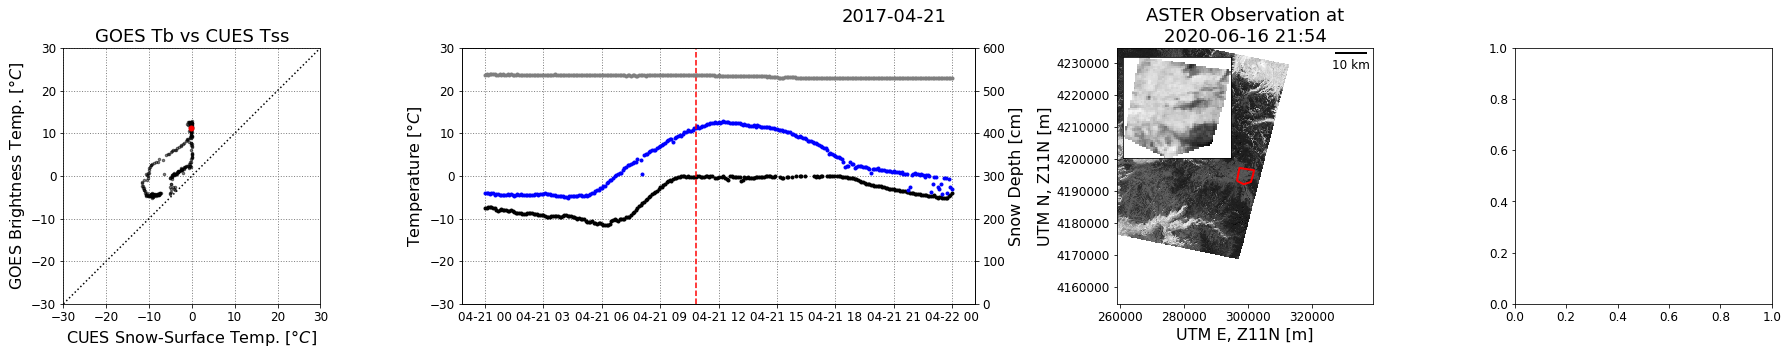

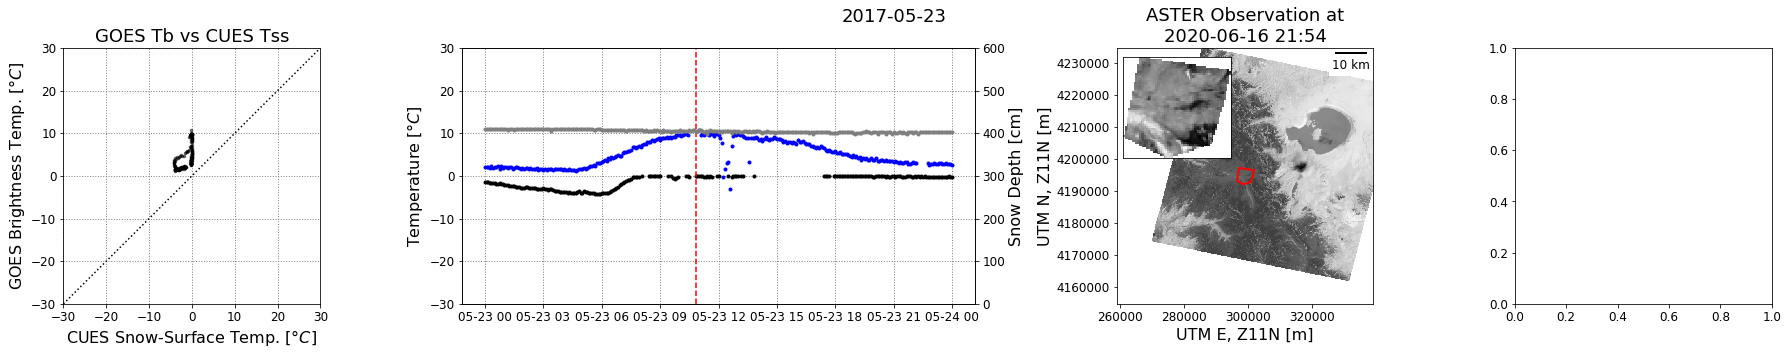

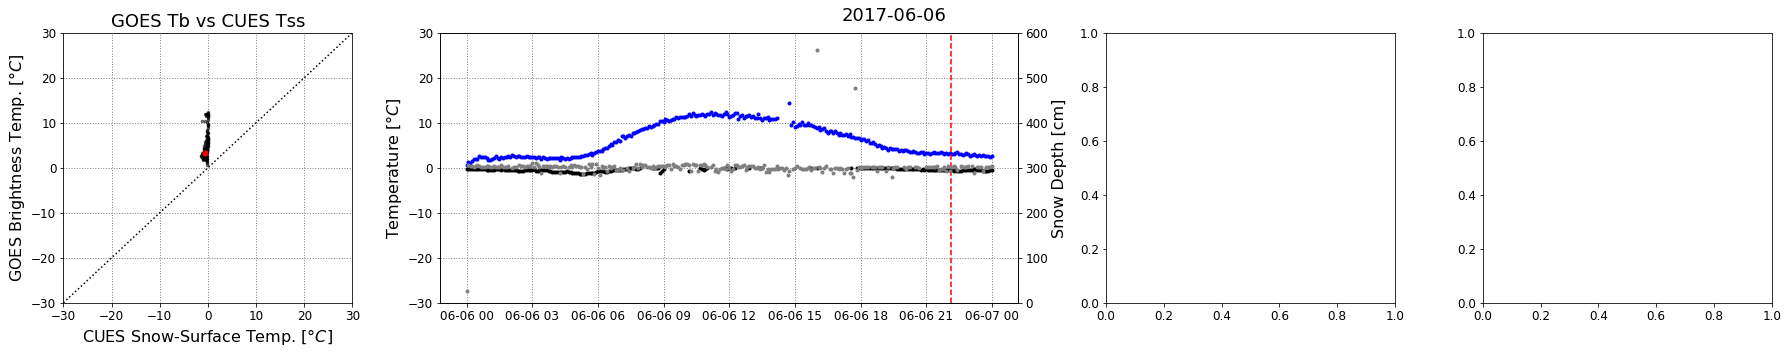

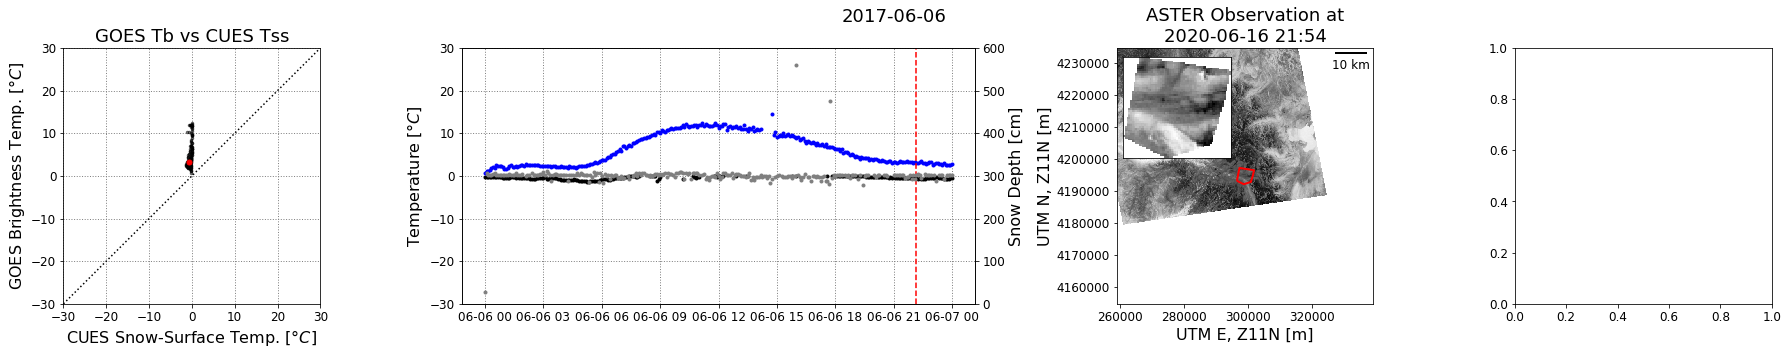

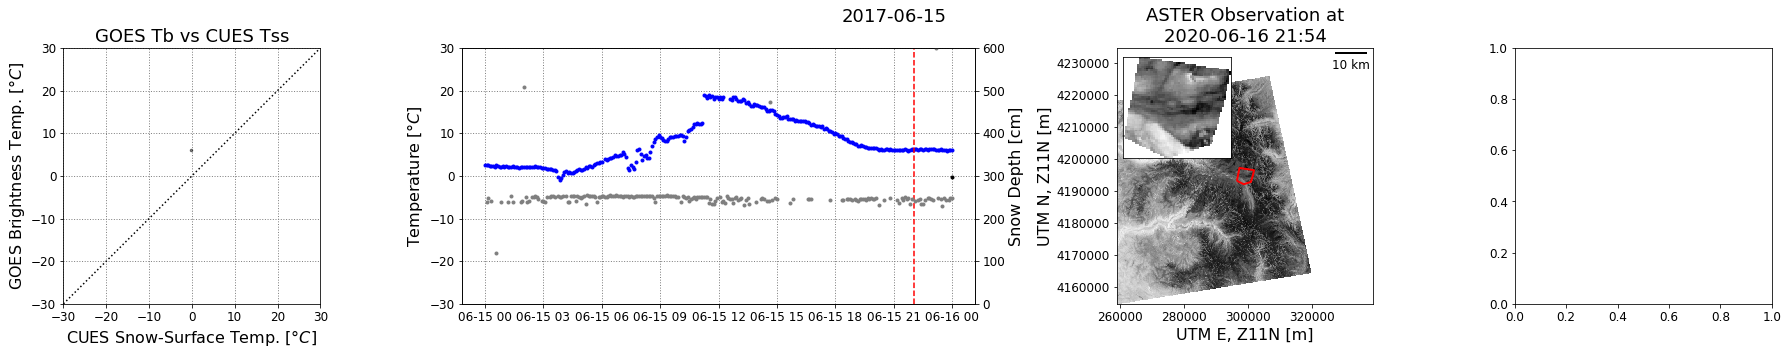

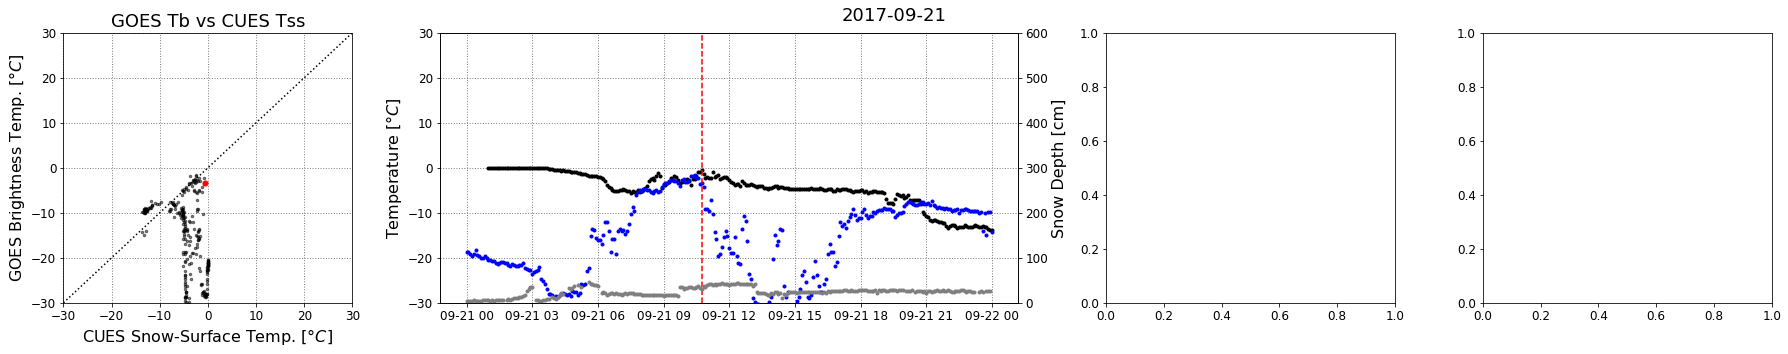

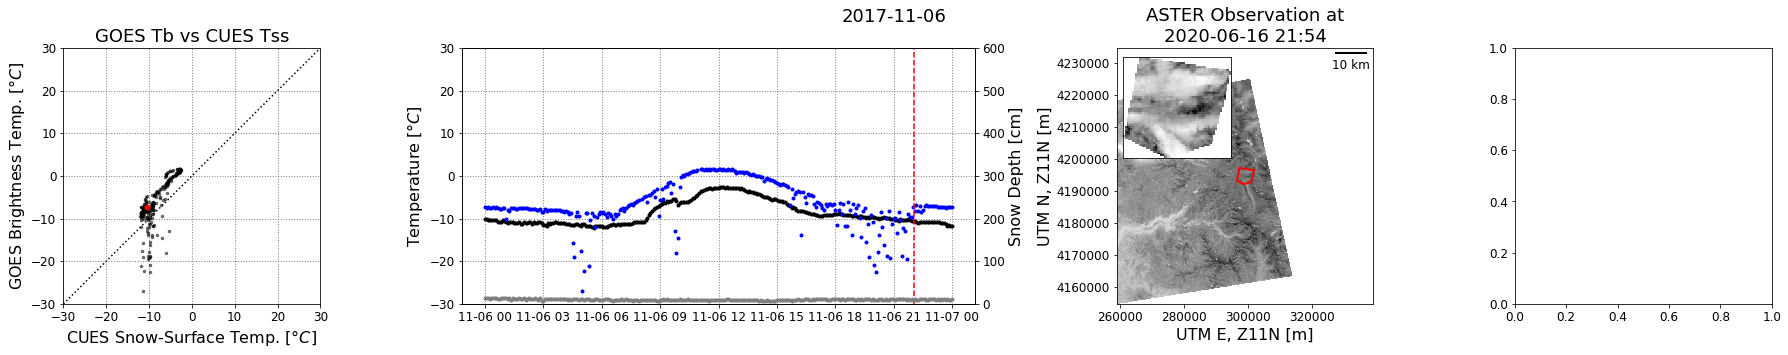

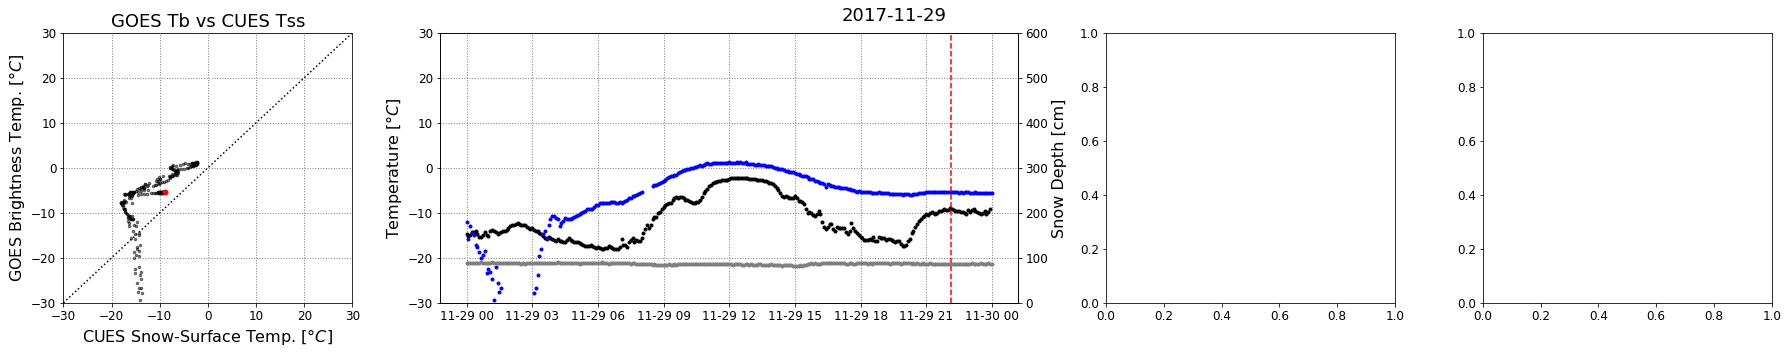

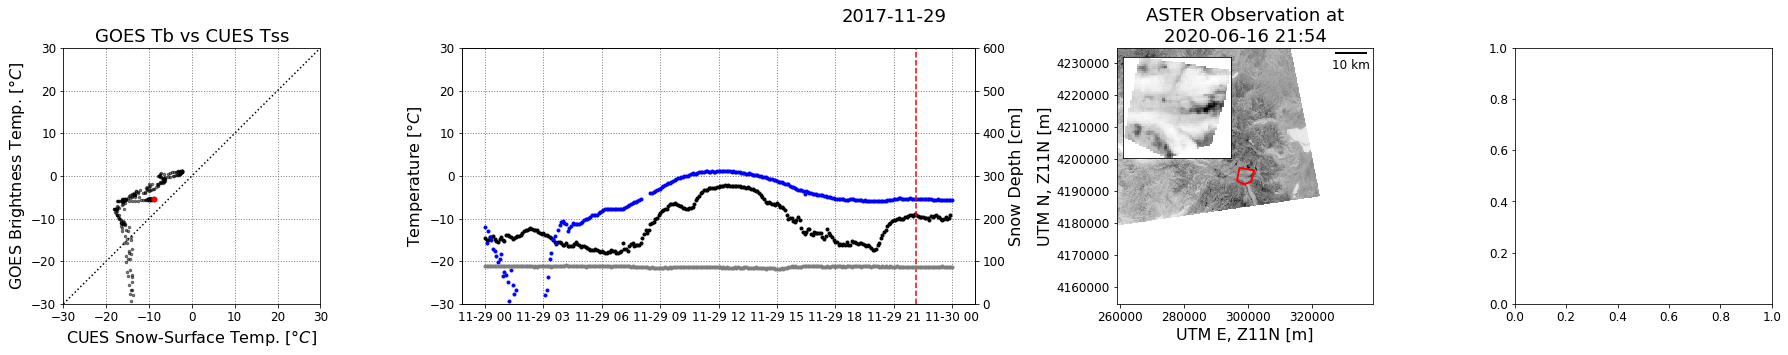

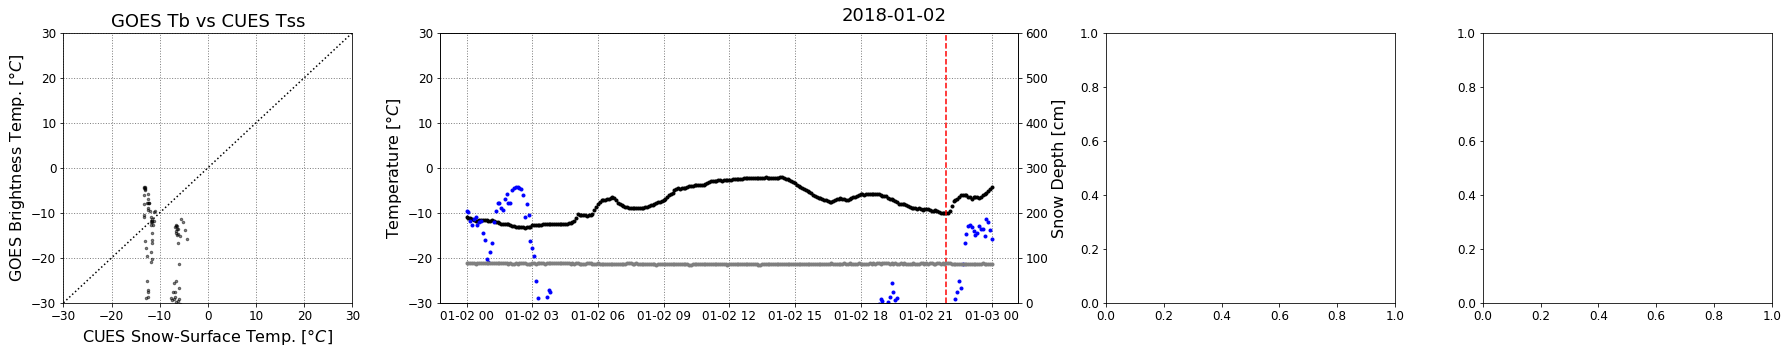

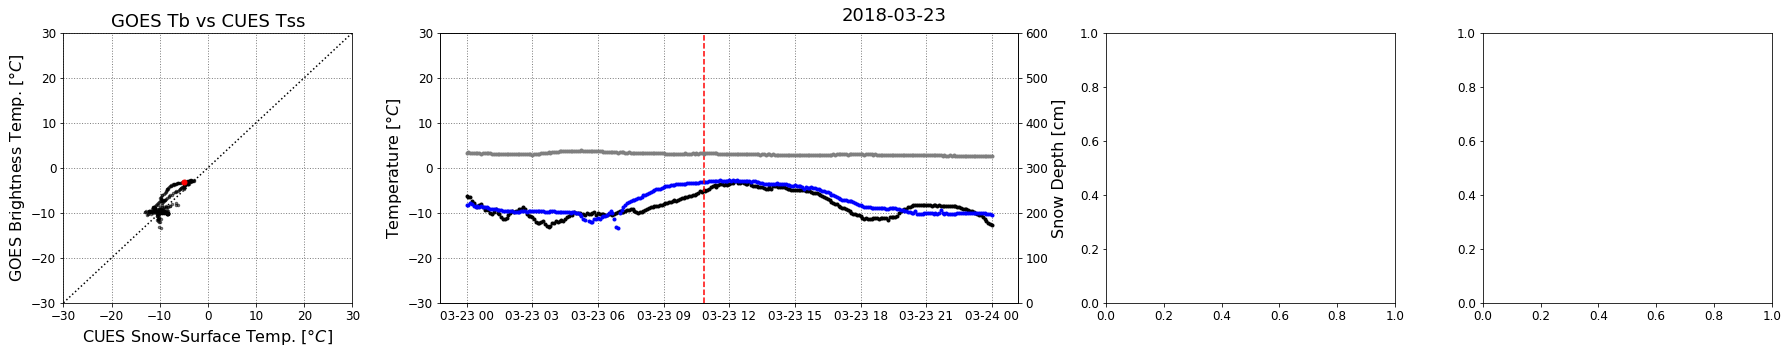

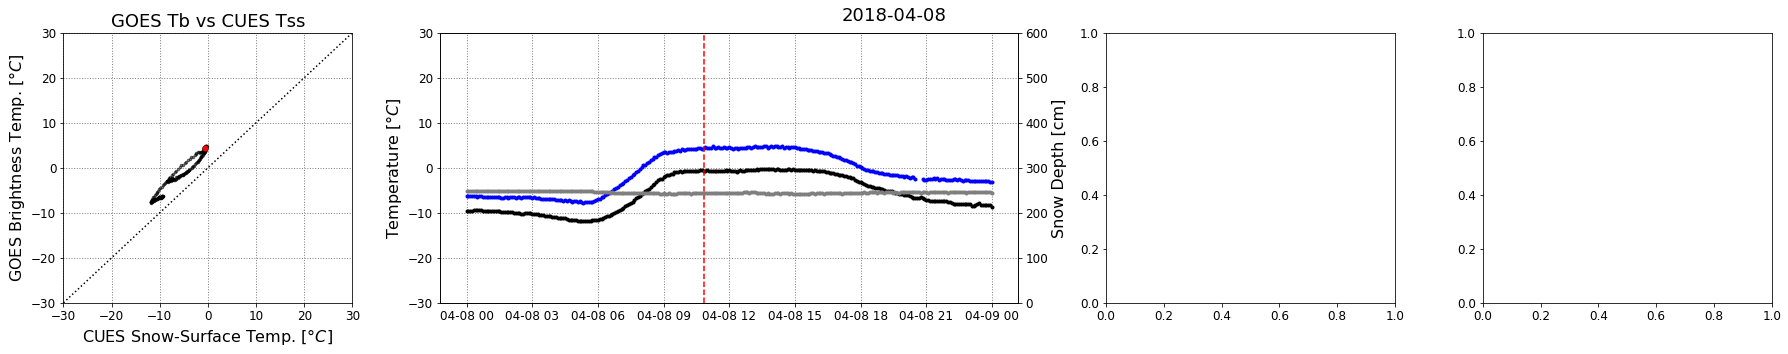

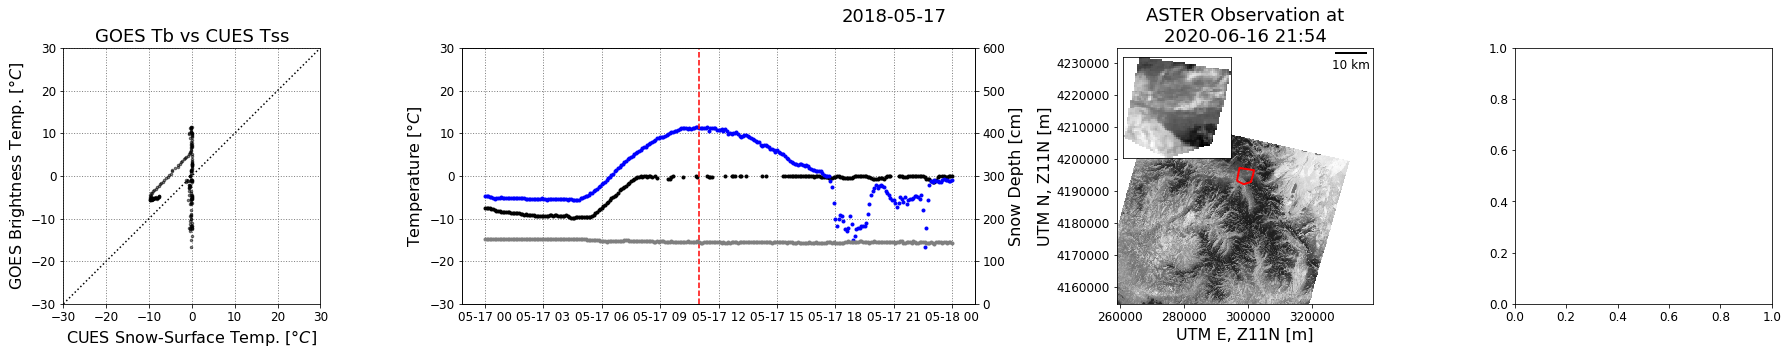

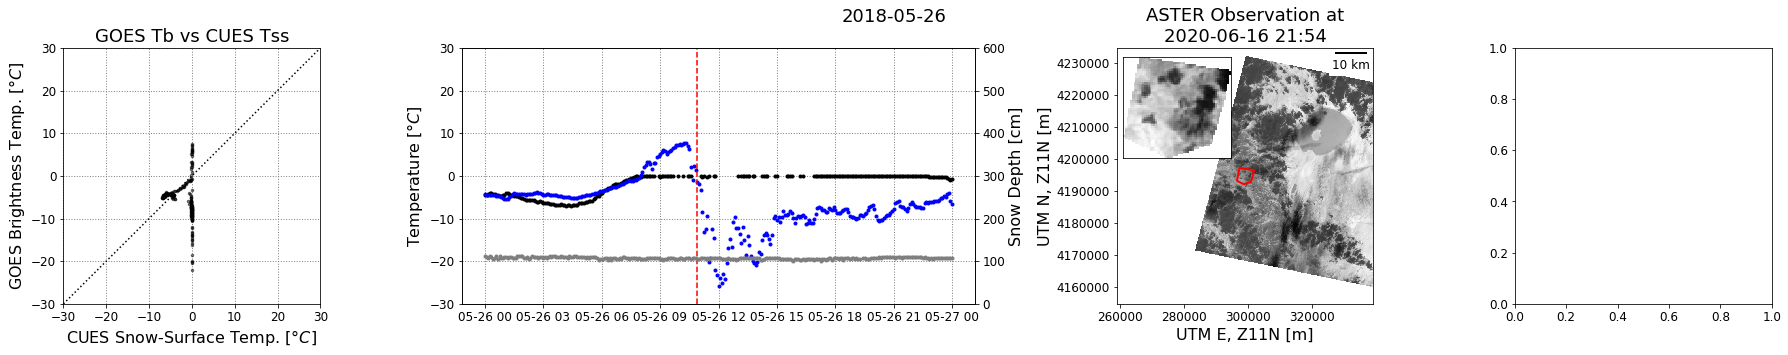

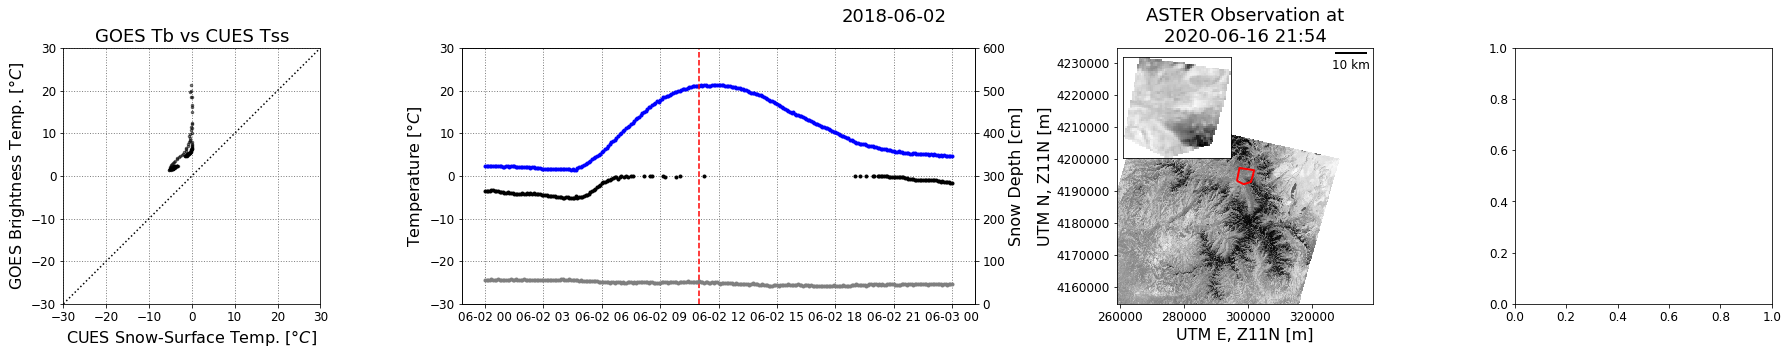

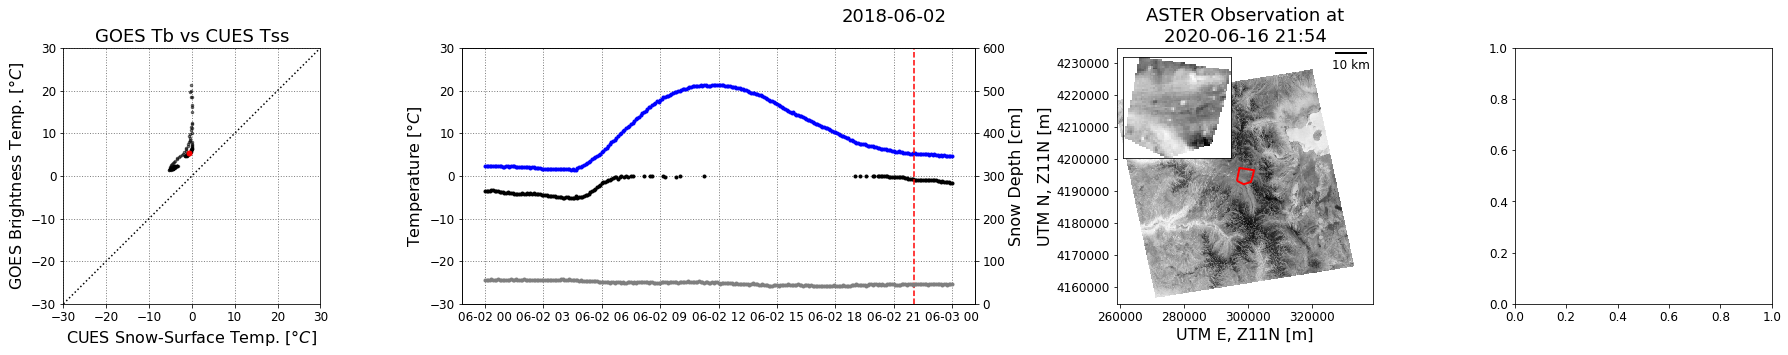

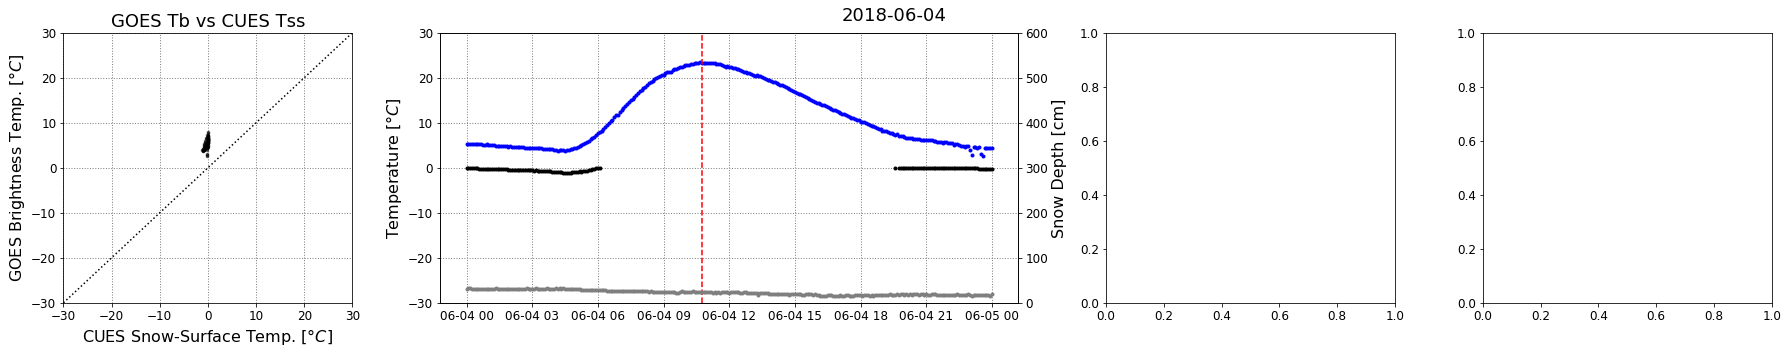

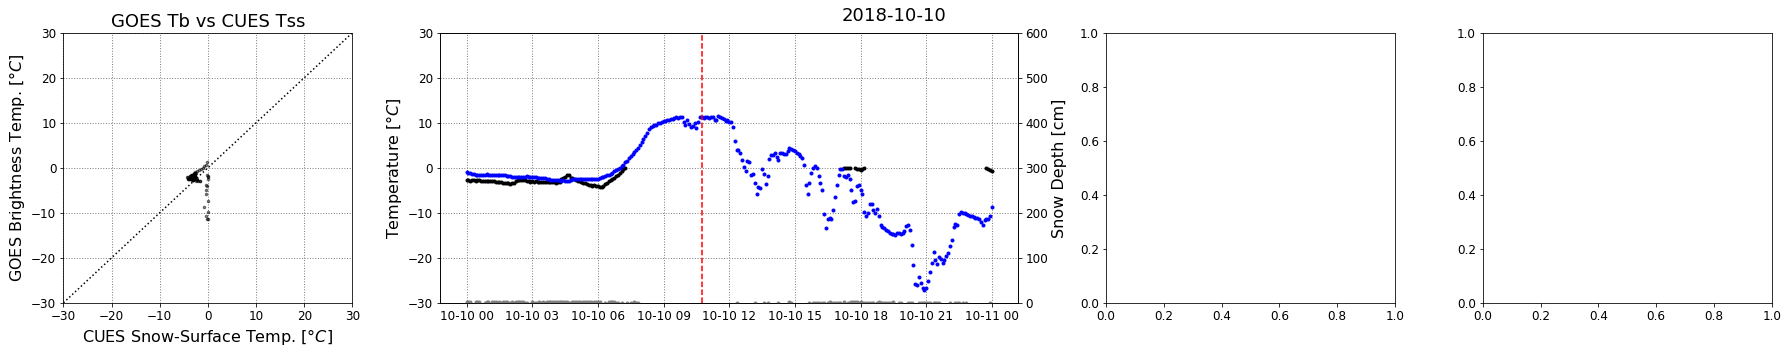

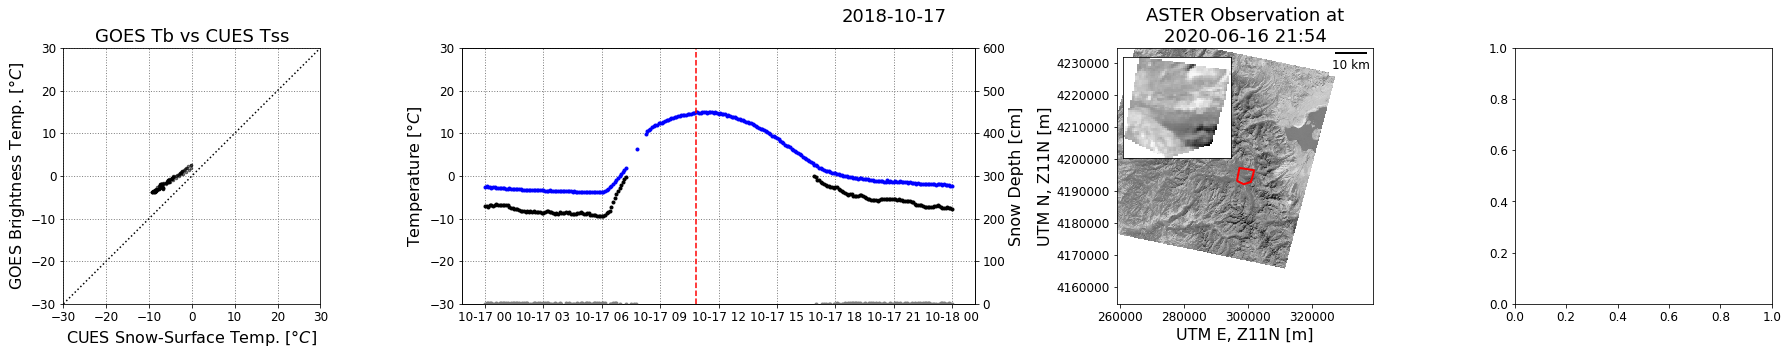

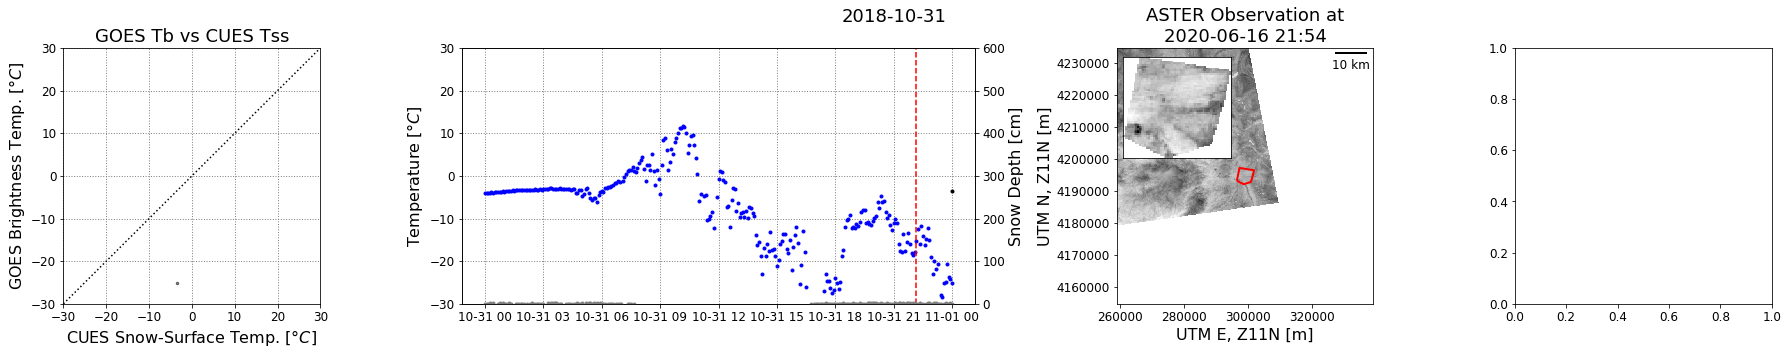

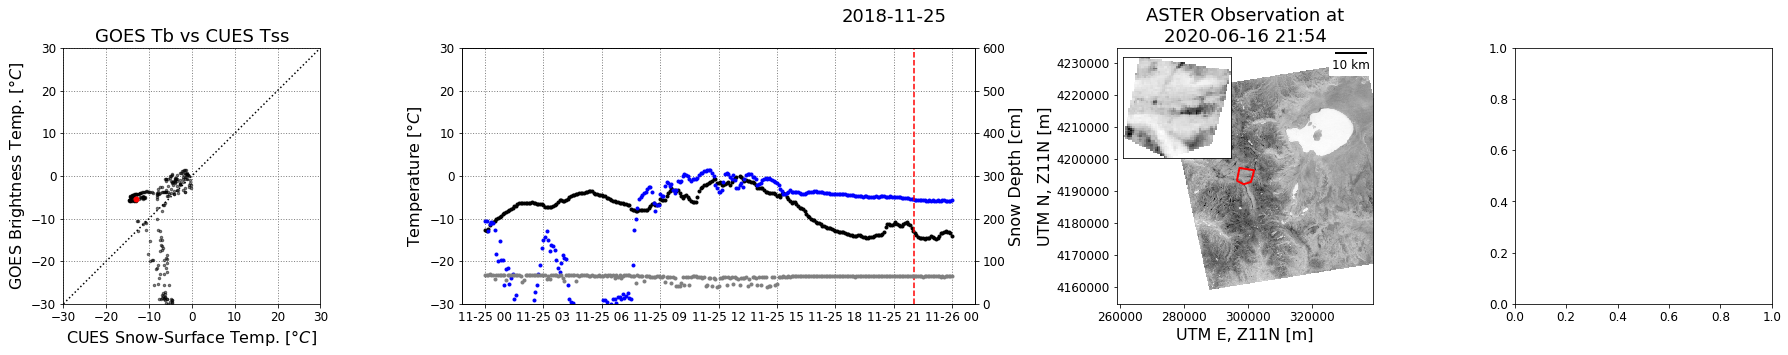

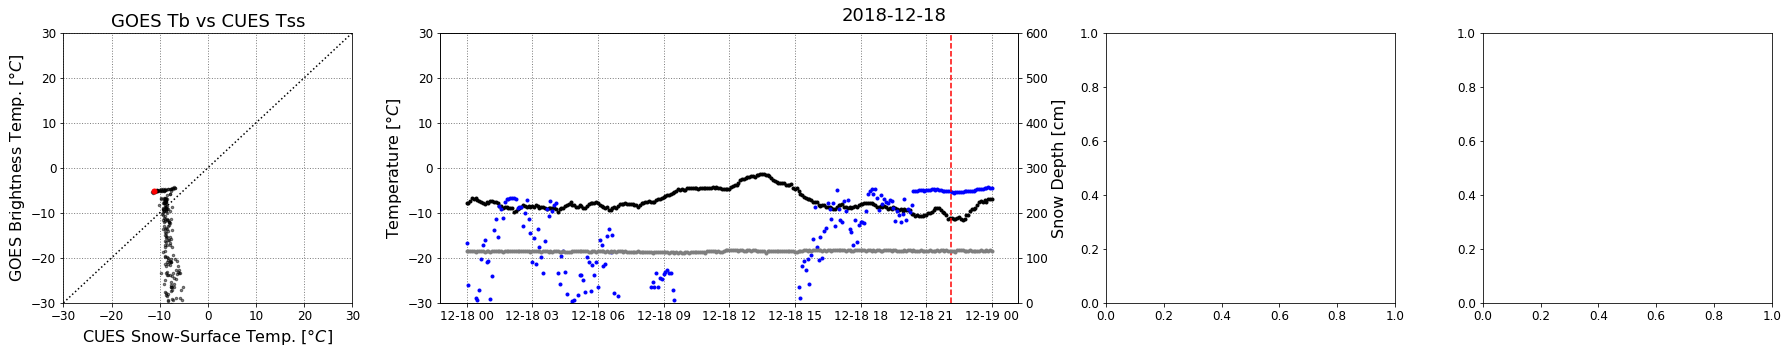

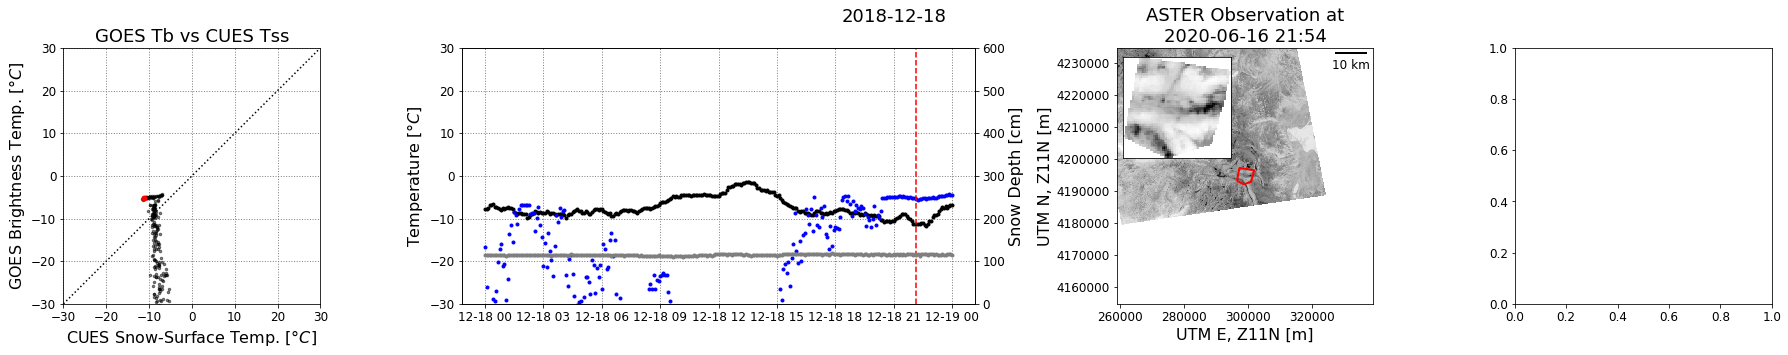

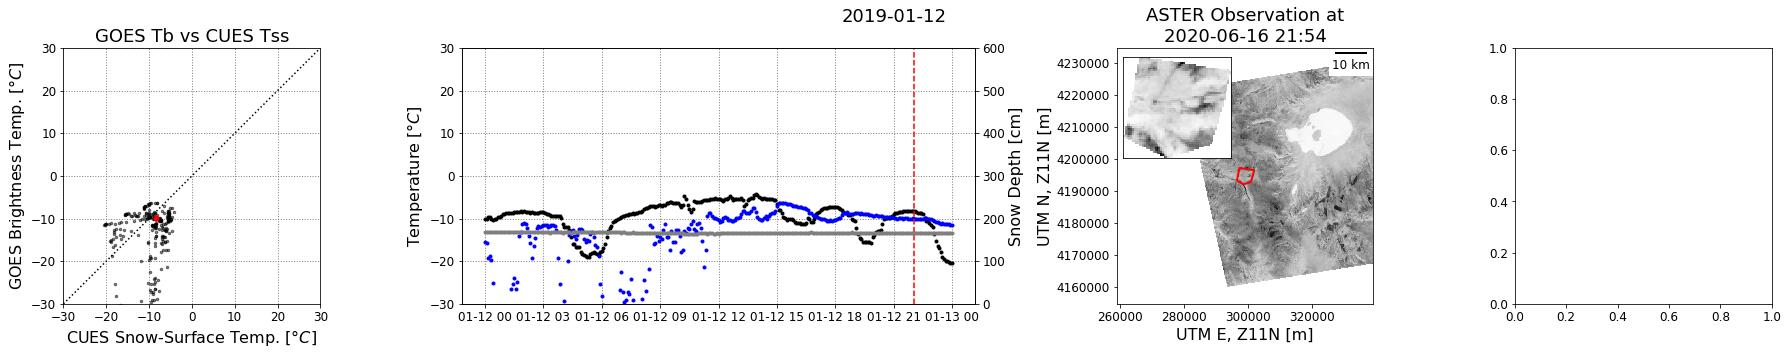

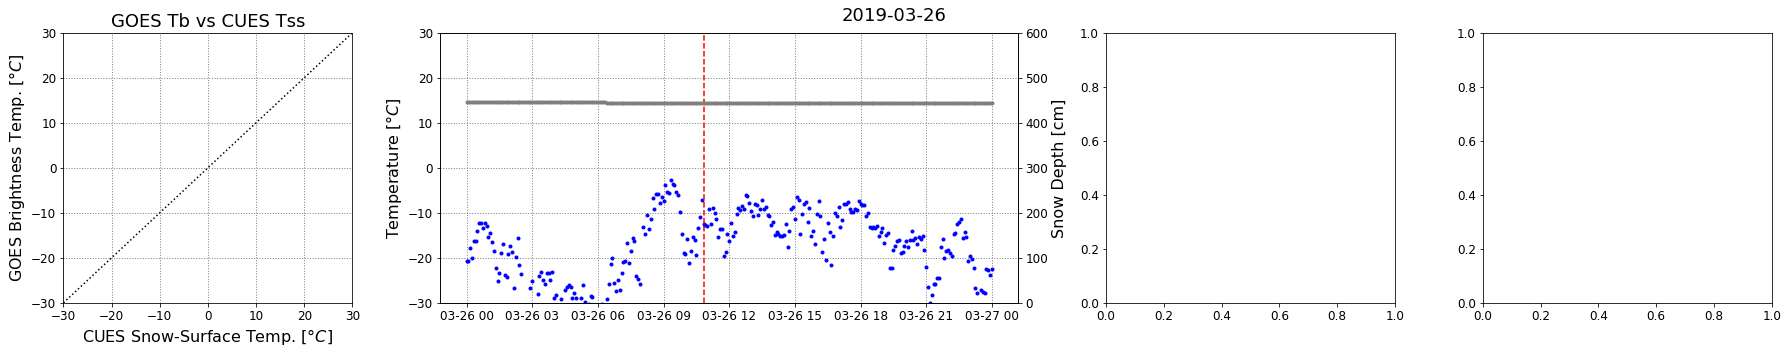

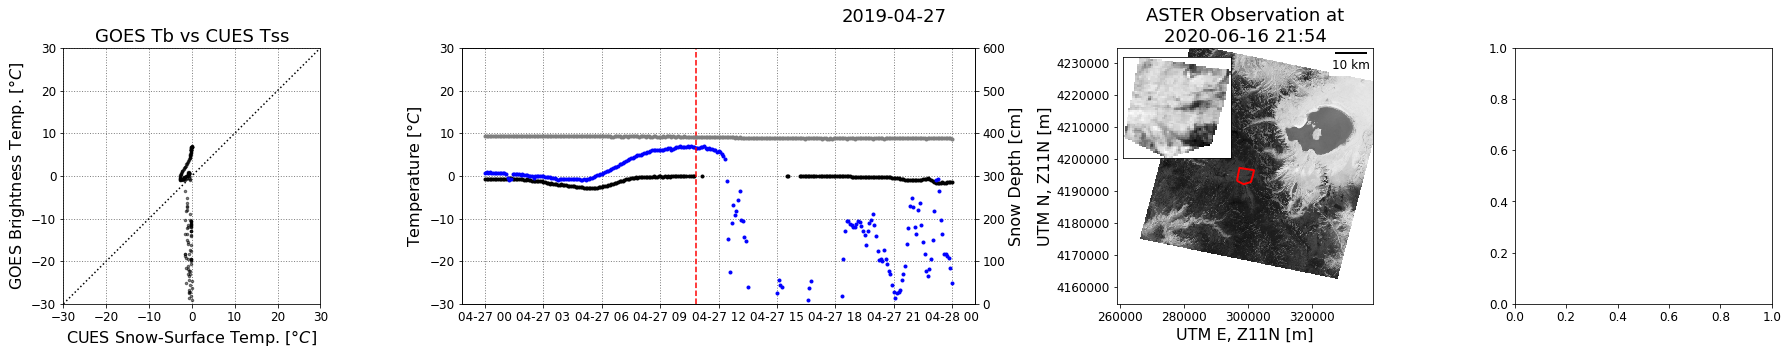

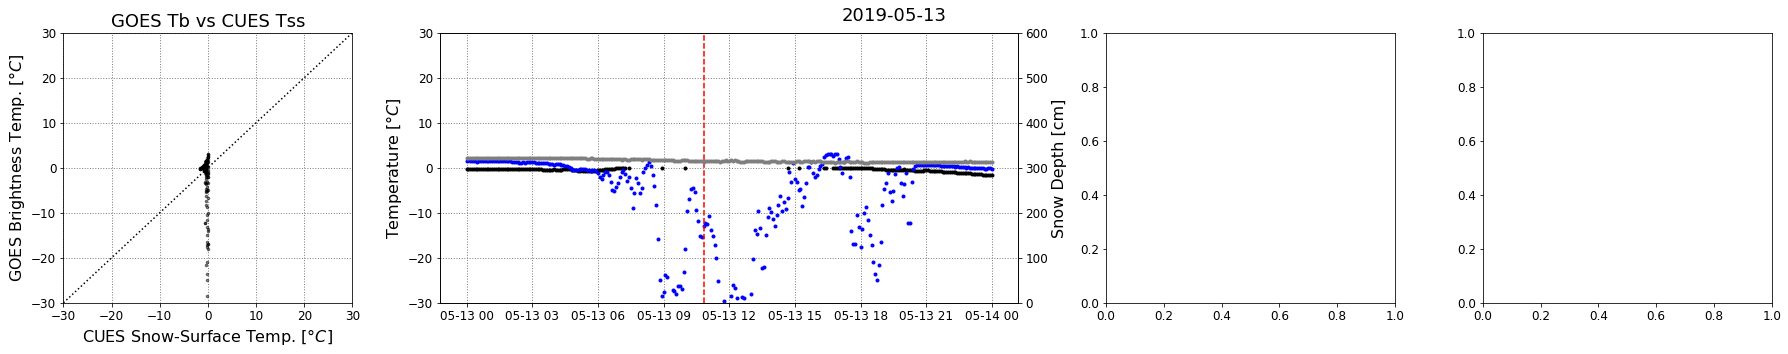

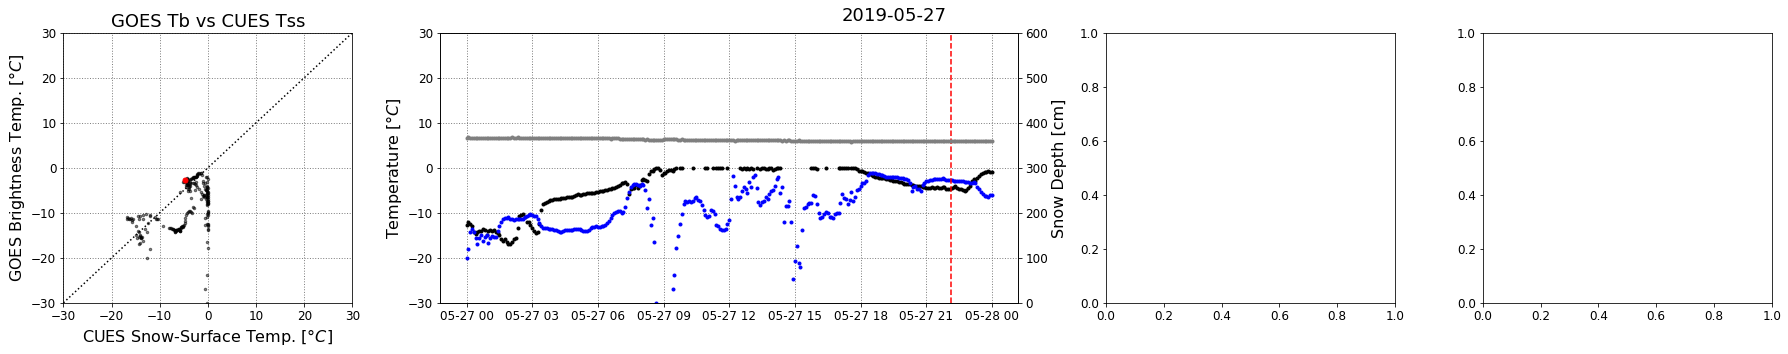

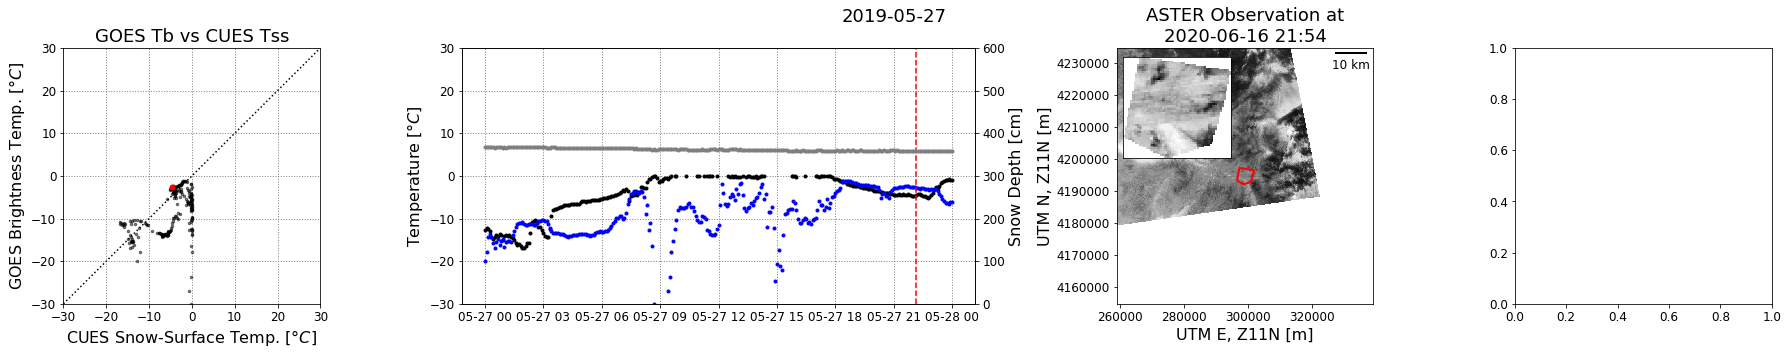

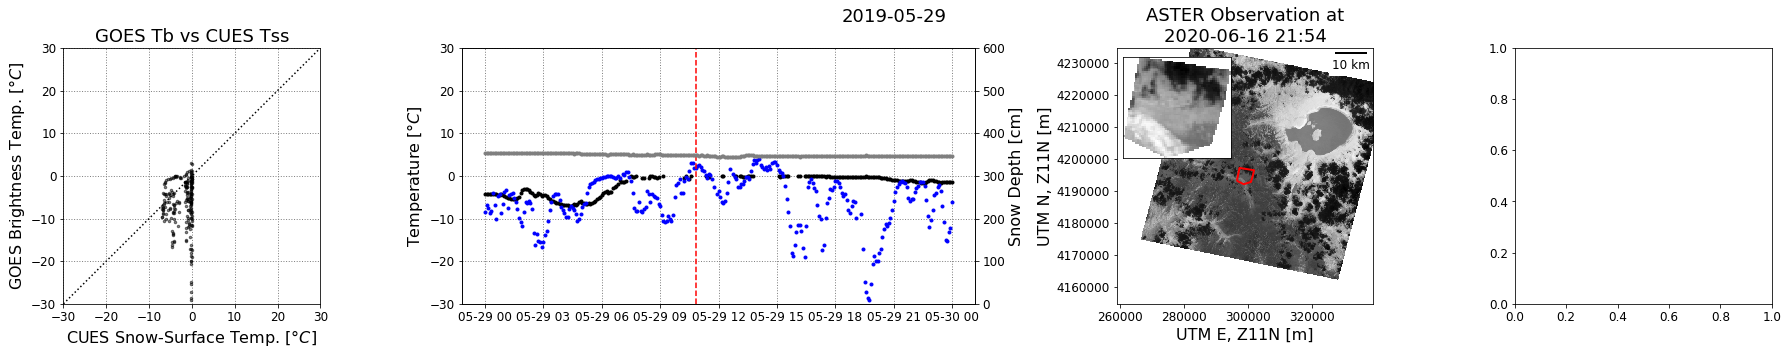

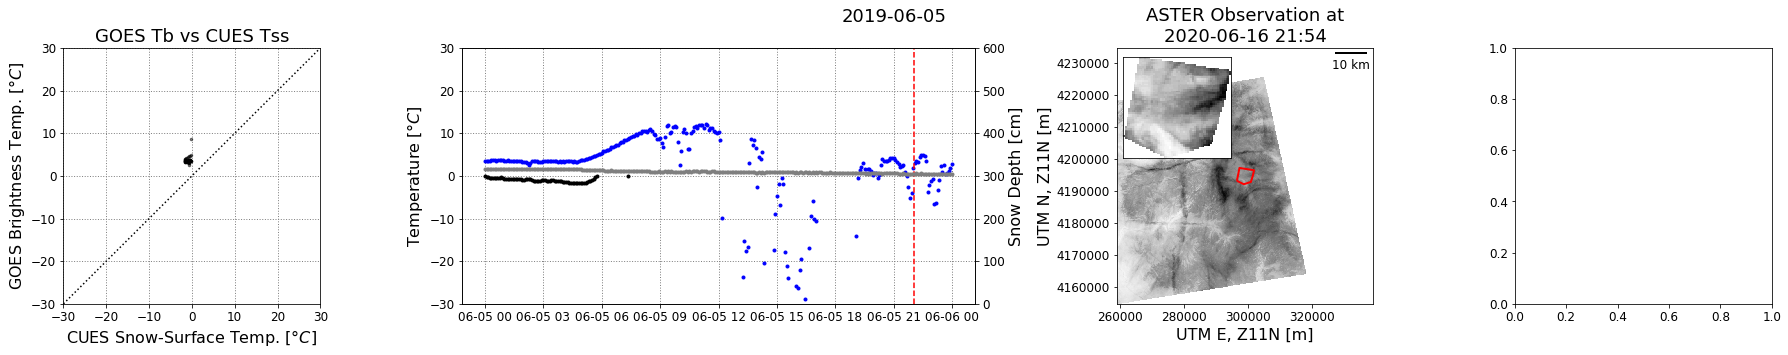

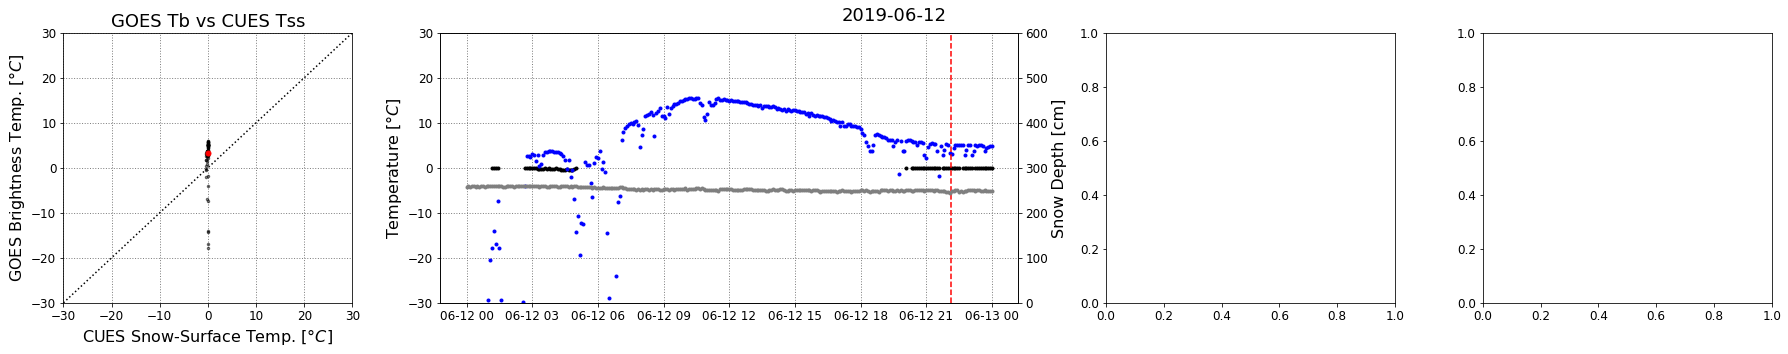

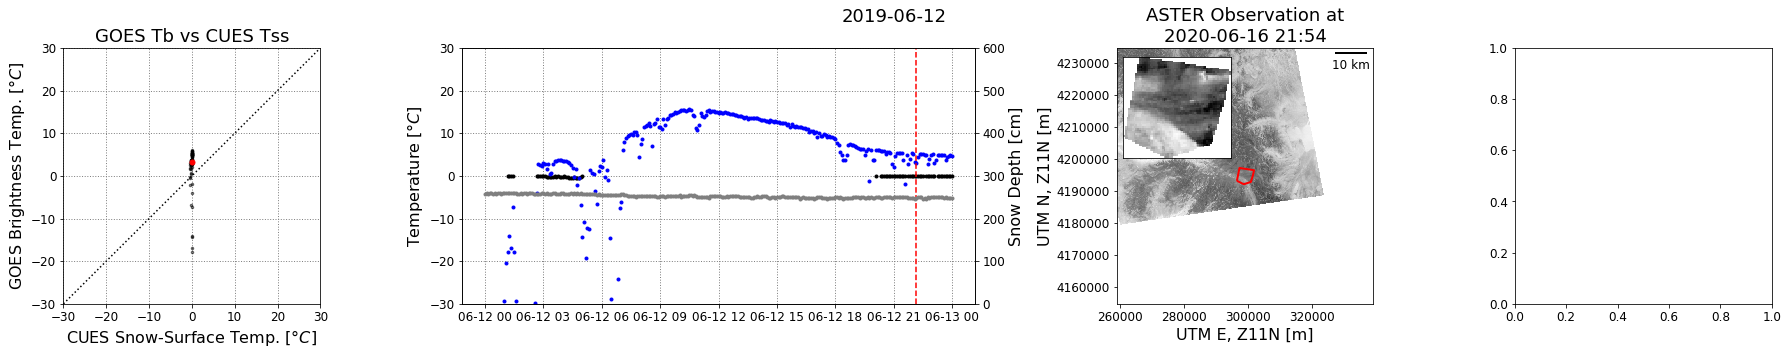

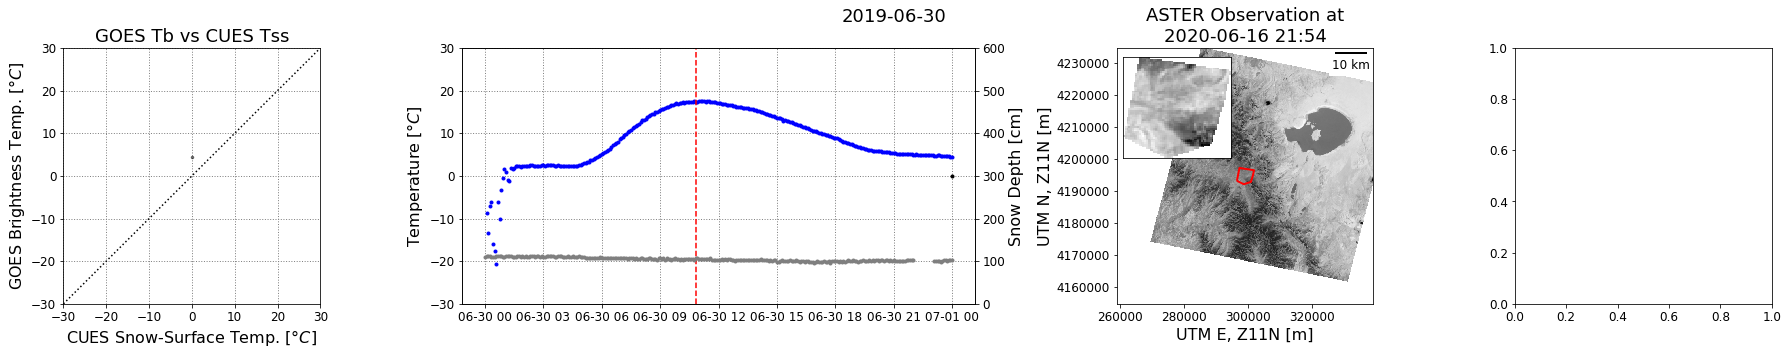

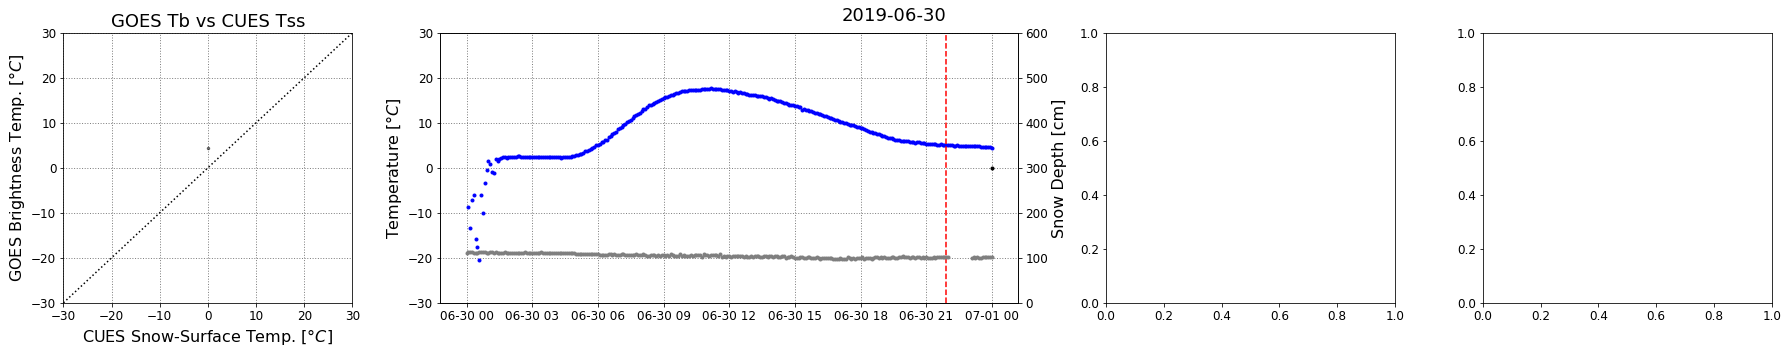

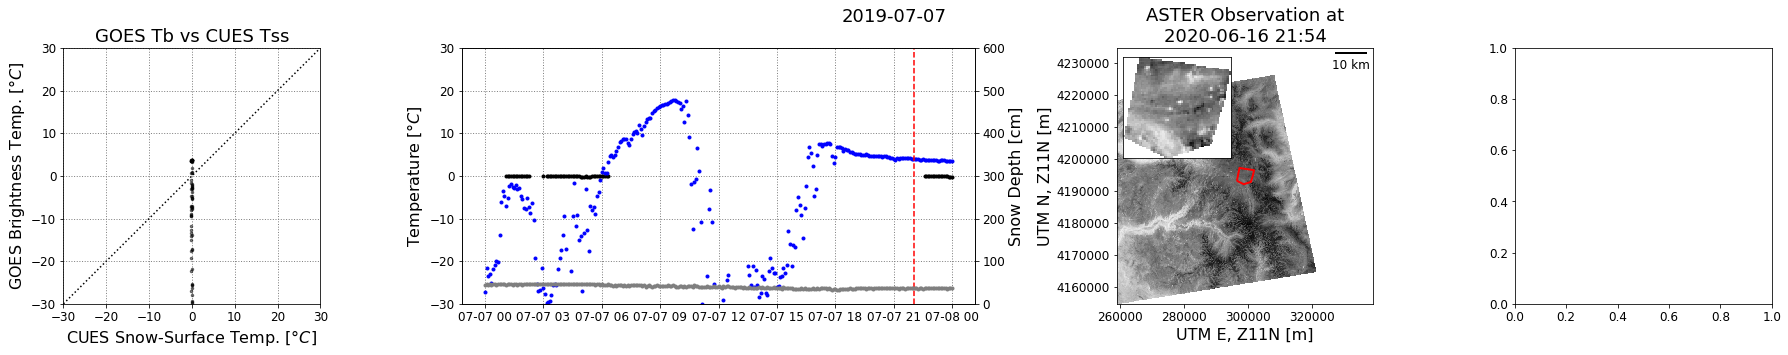

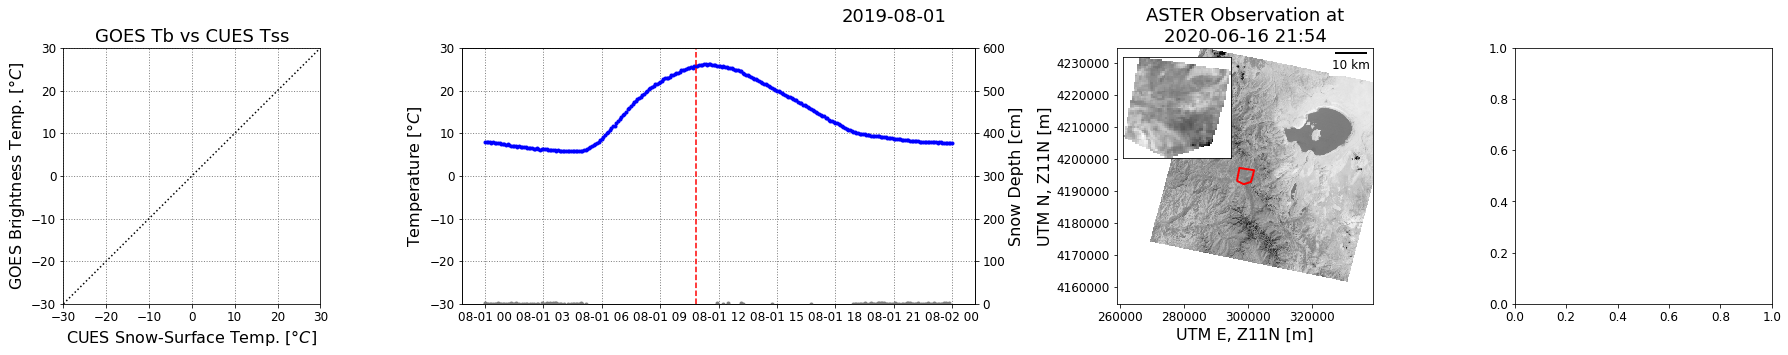

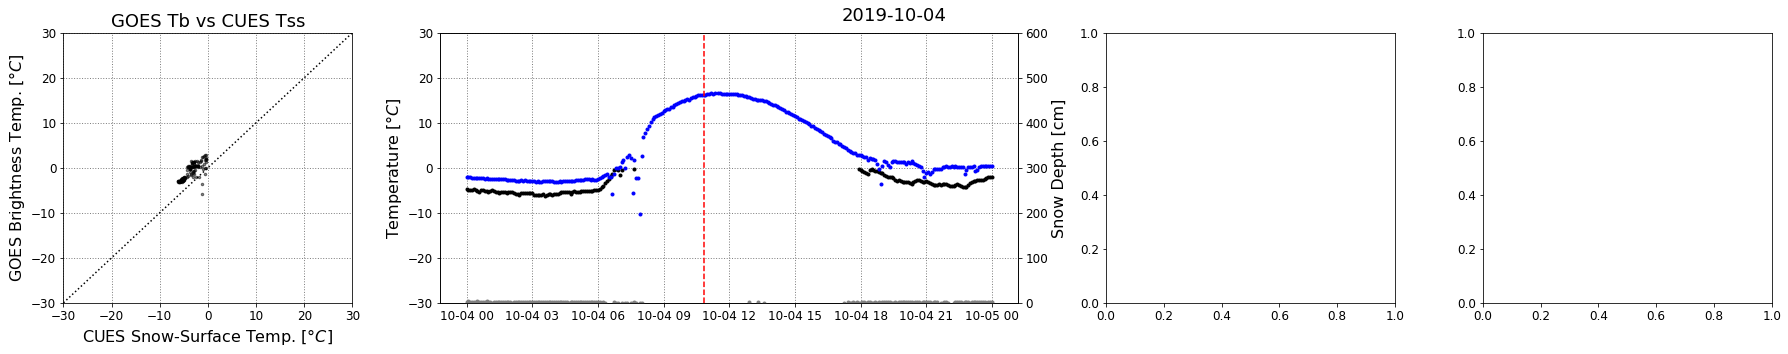

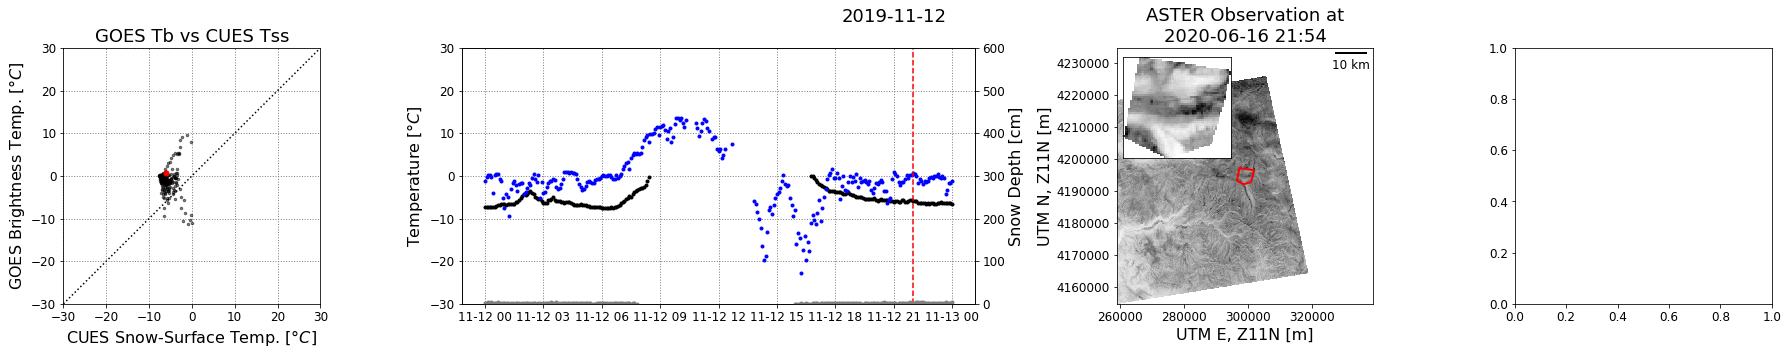

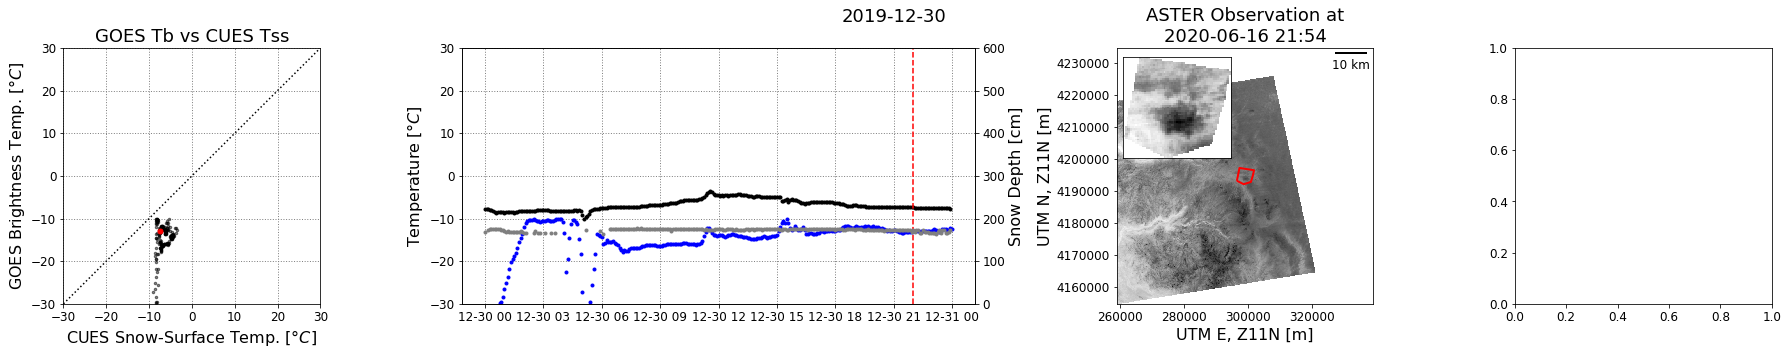

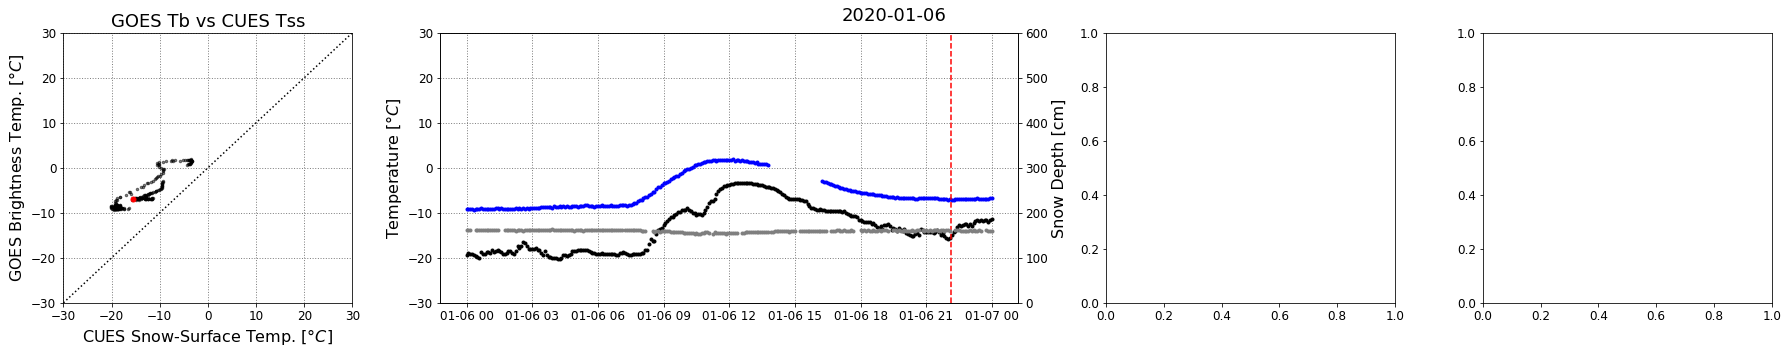

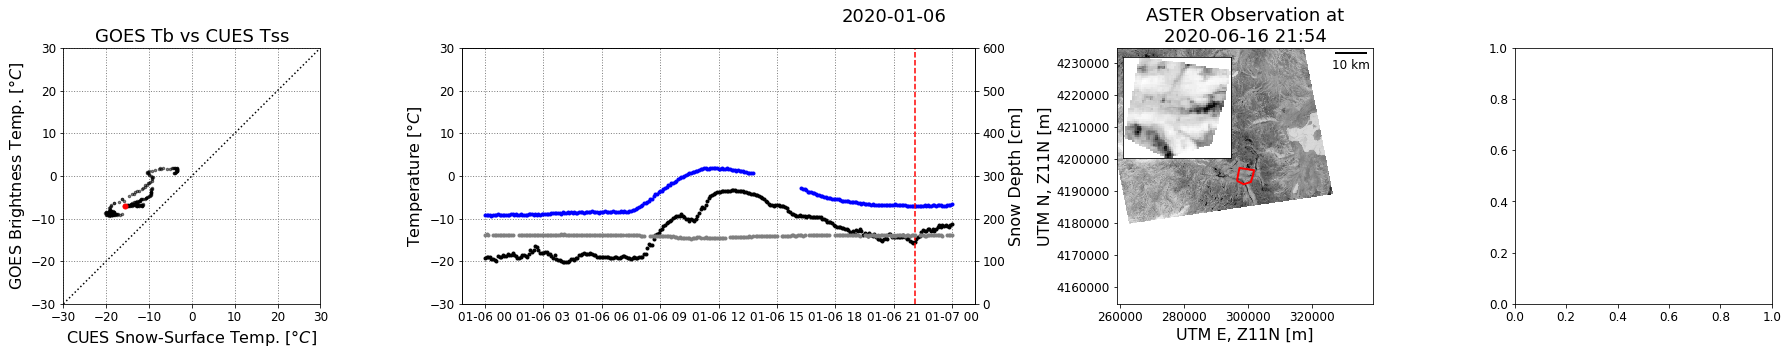

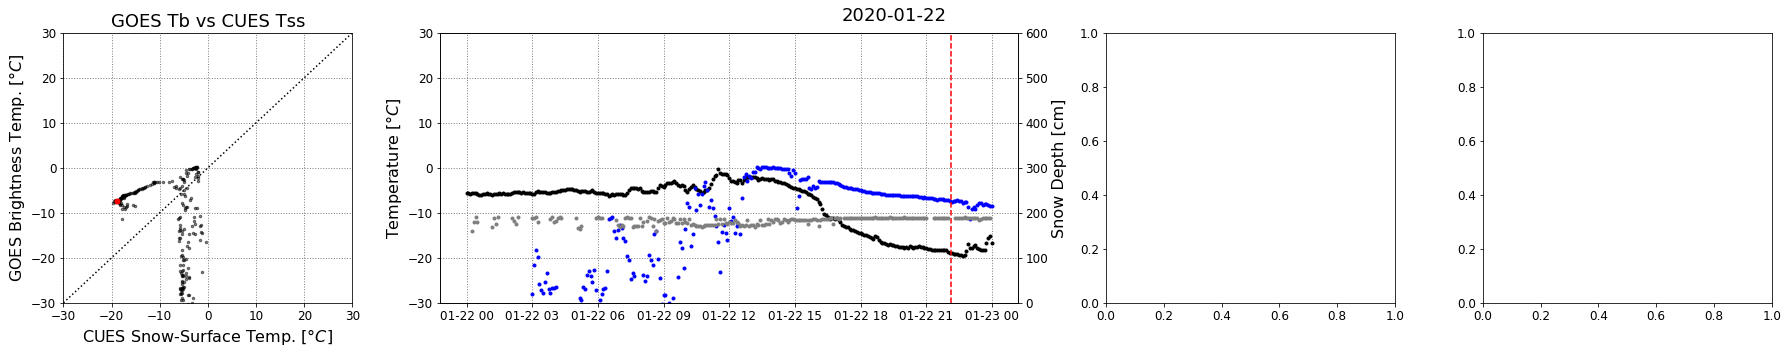

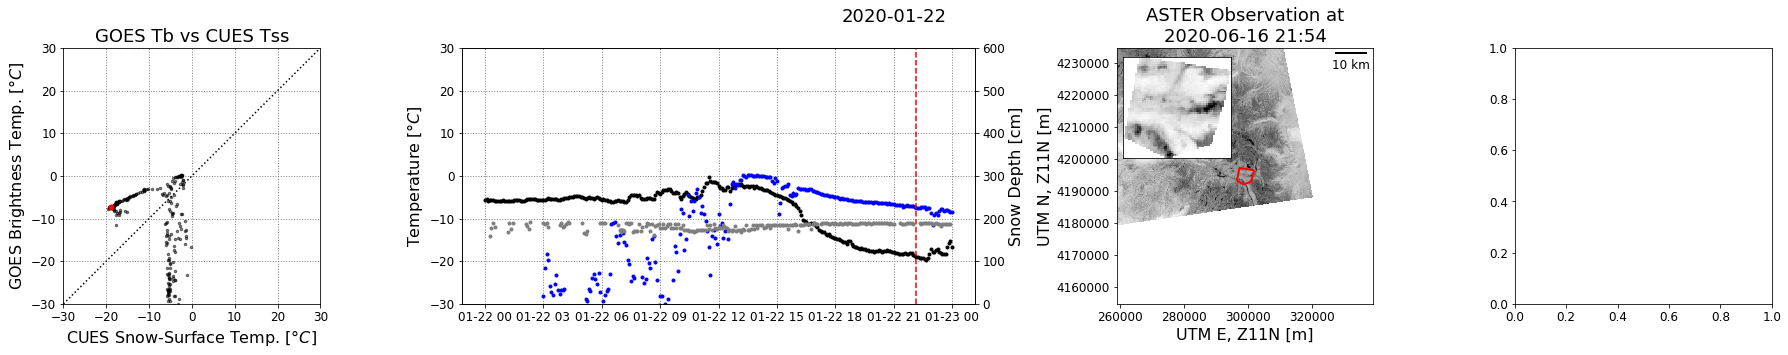

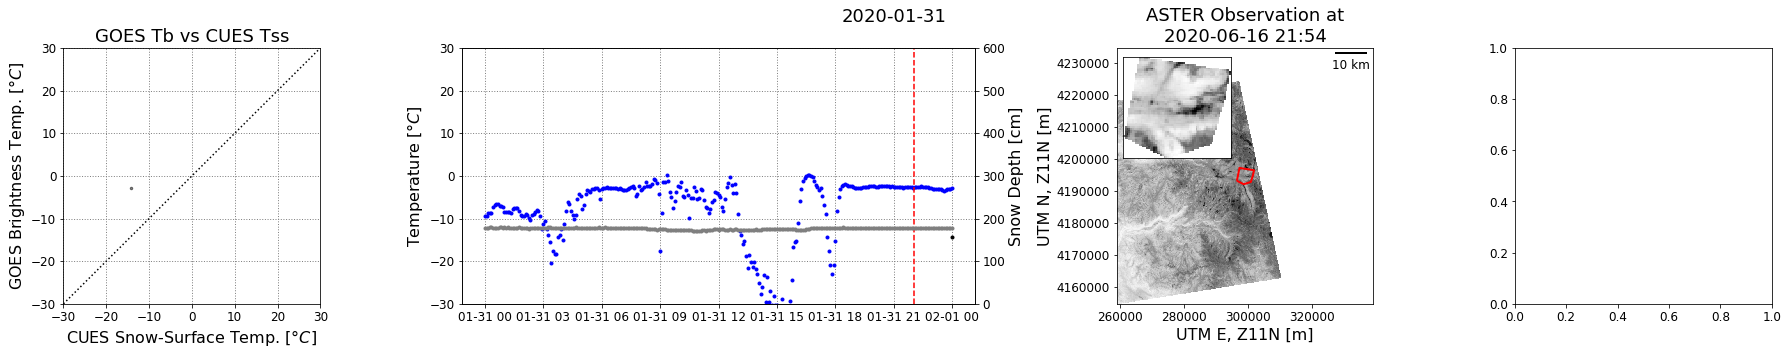

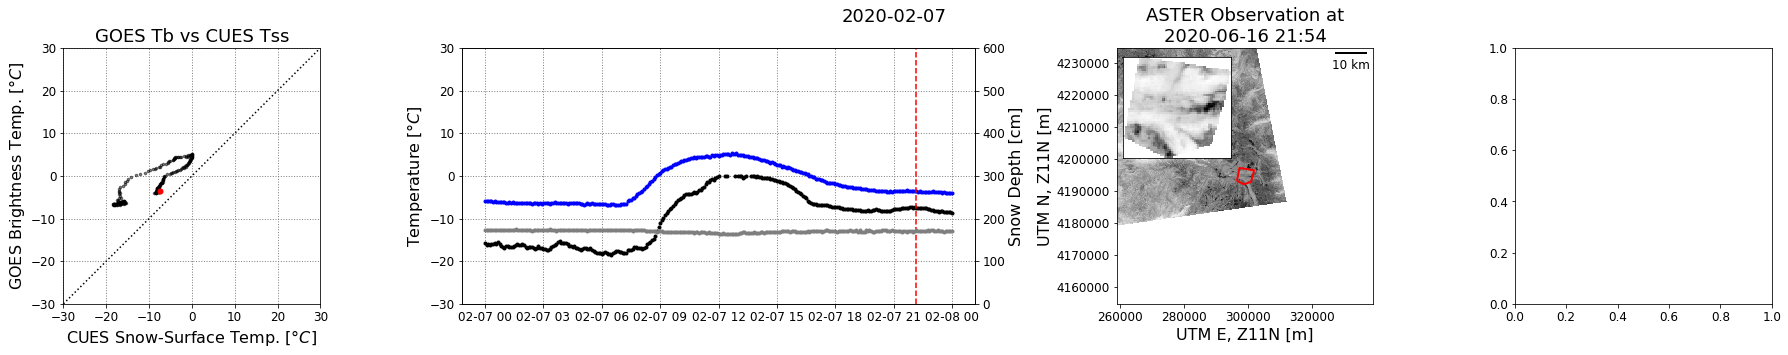

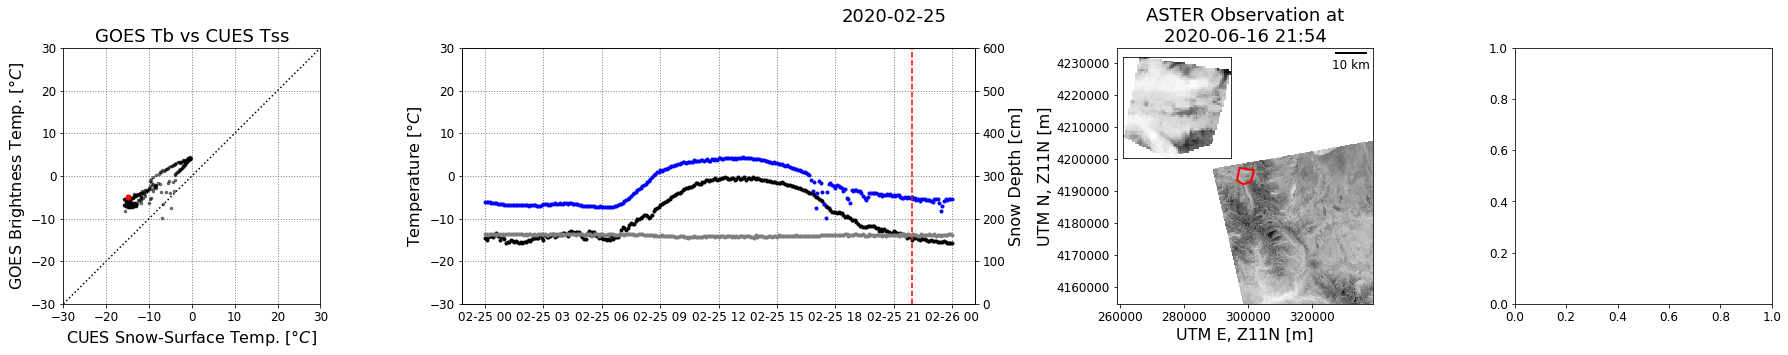

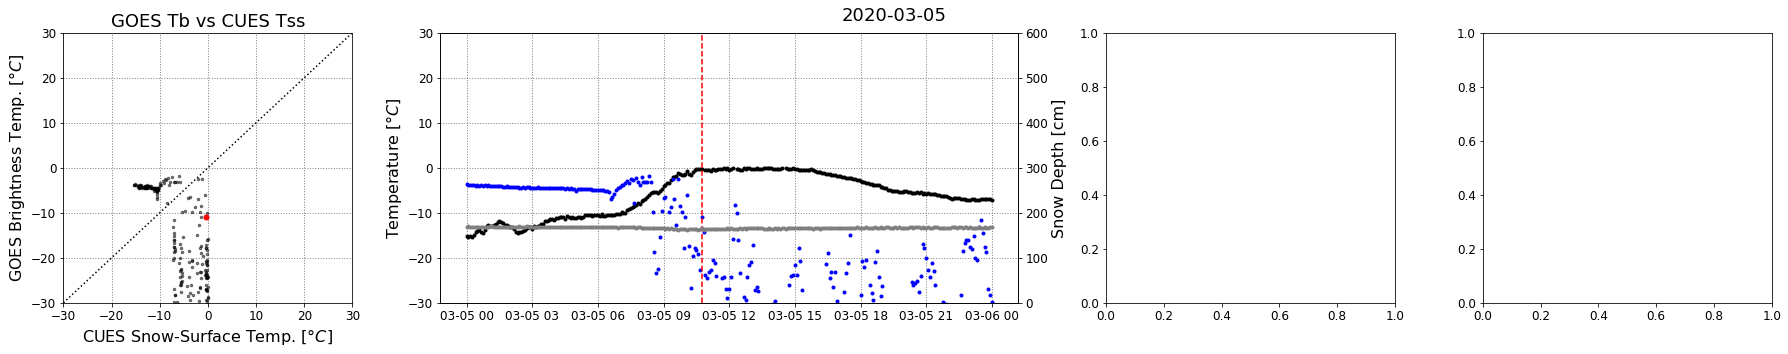

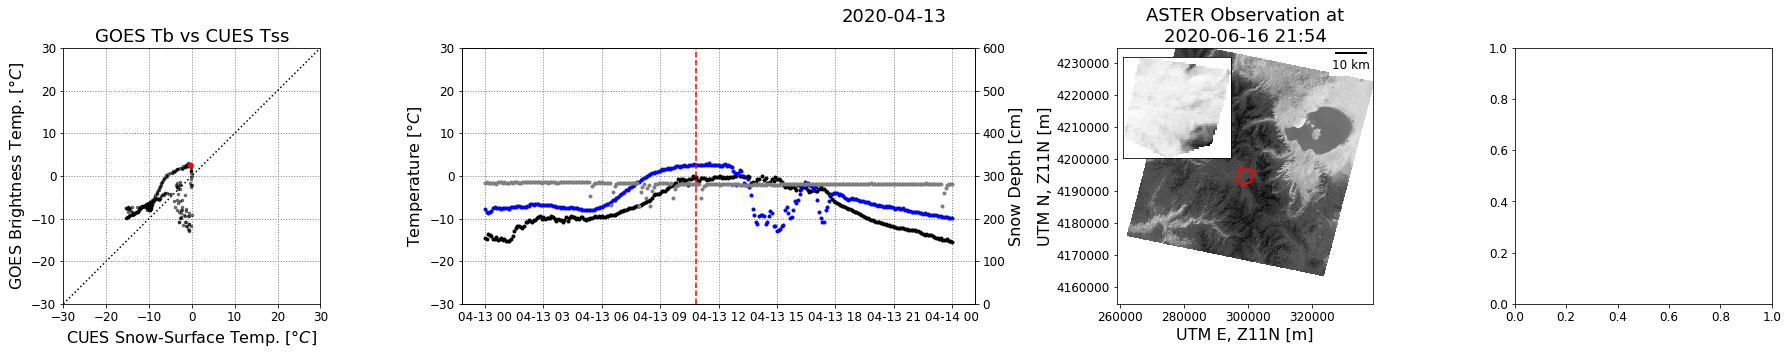

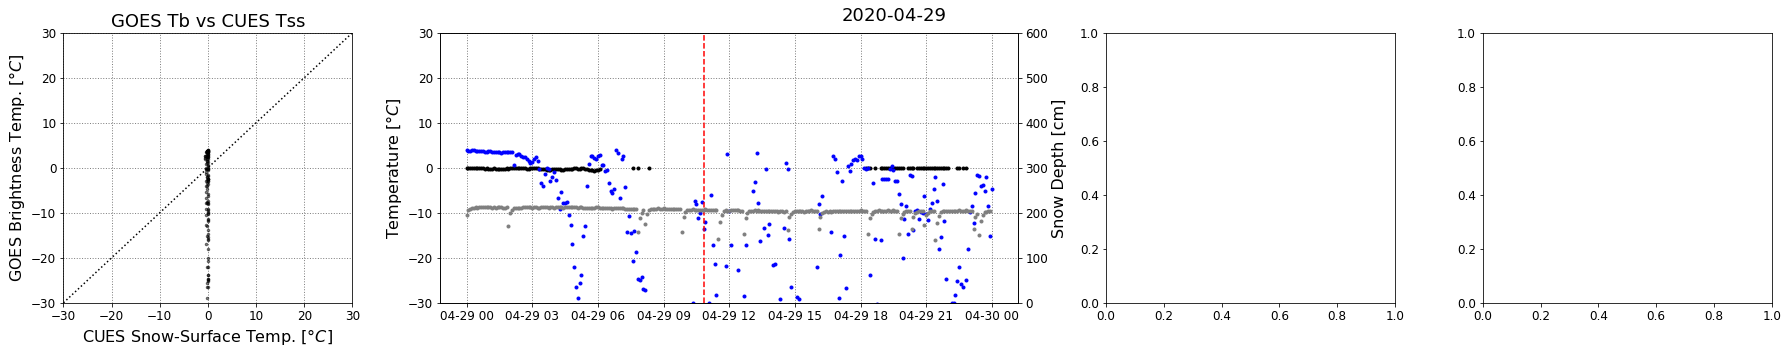

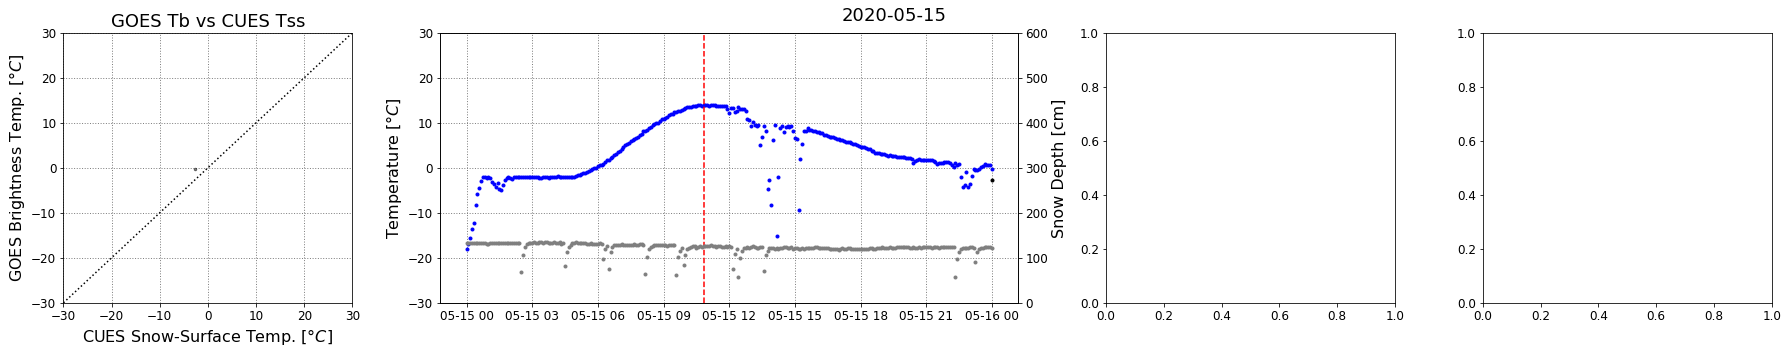

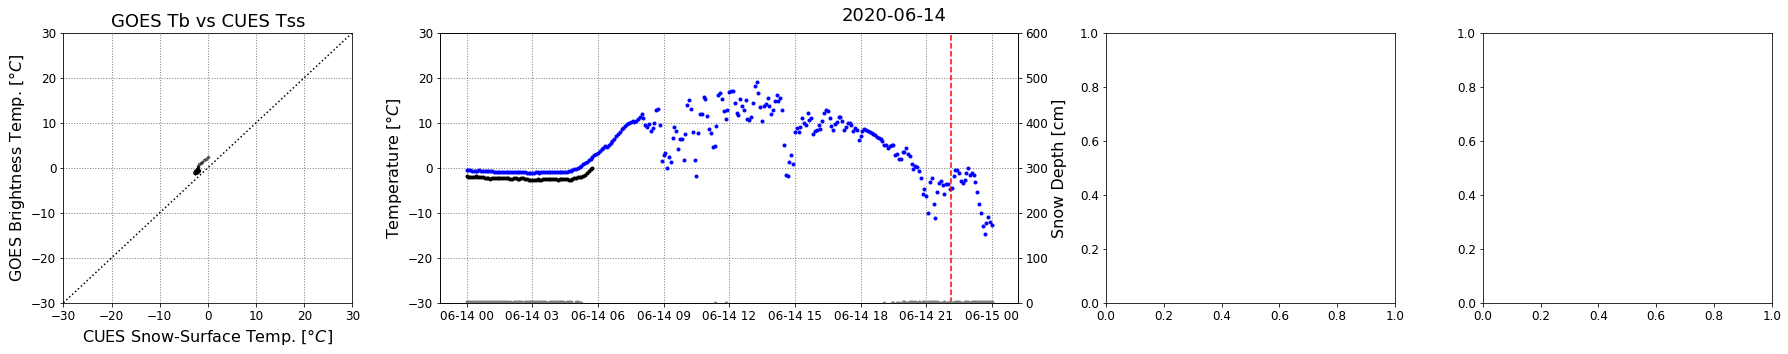

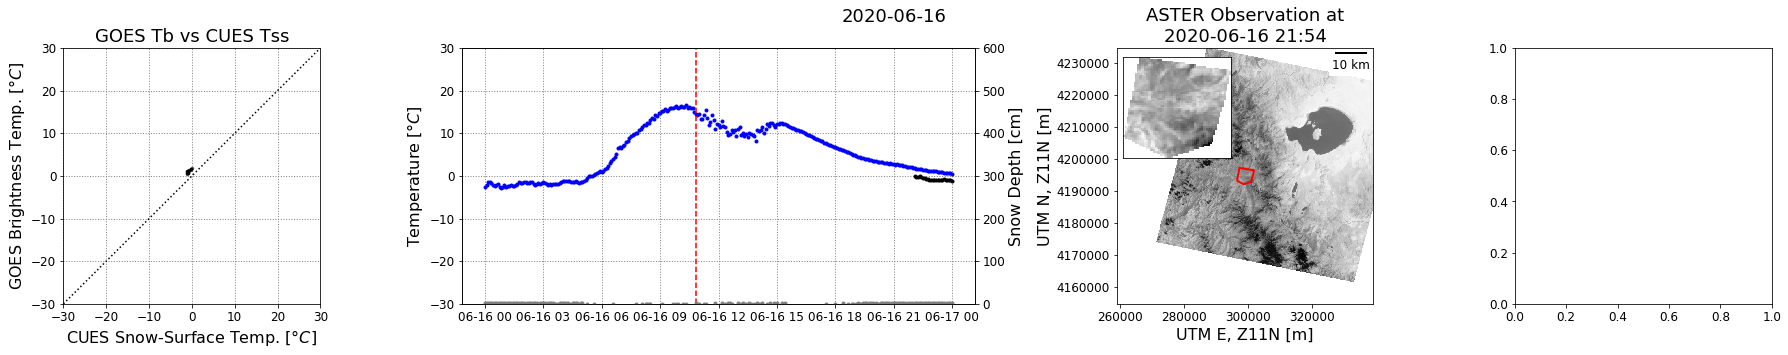

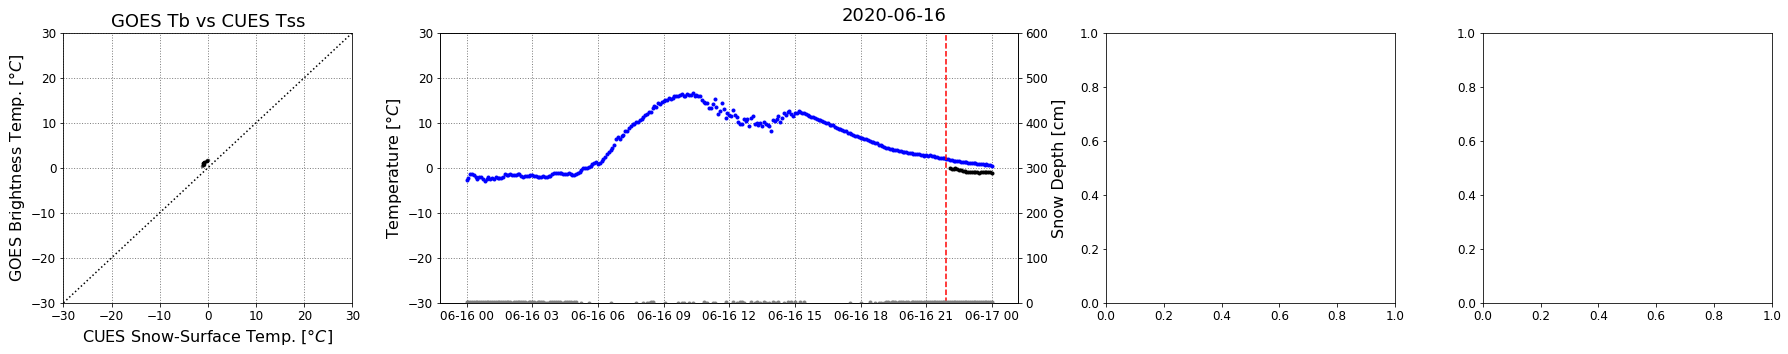

In [13]:
x = cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
x_label = 'CUES Snow-Surface Temp. [$\degree C$]'

y = cues_ds.goes_tb_c
y_label = 'GOES Brightness Temp. [$\degree C$]'

t = cues_ds.datetime

snowdepth = cues_ds['snow depth  remote boom;  ultrasonic depth pinger on remote boom; (cm)']

# shapefile for zonal statistics:
shapefile_filepath = r"C:\Users\steve\Desktop\test1.shp"
zone_shape = gpd.read_file(shapefile_filepath)

for index, row in aster.iterrows():
        
    single_filepath = os.path.normpath(row.filepath)    
    single_datetime = row.datetime
    
    startdate = pd.Timestamp(single_datetime.strftime("%Y-%m-%d"))
    enddate = startdate + pd.Timedelta(hours=24)
    
    #print(startdate, enddate)
    
    _x = x.sel(datetime=slice(startdate, enddate))
    _y = y.sel(datetime=slice(startdate, enddate))
    _x_nearest_aster = x.sel(datetime=np.datetime64(single_datetime),method='nearest')
    _y_nearest_aster = y.sel(datetime=np.datetime64(single_datetime),method='nearest')
    #print(_x_nearest_aster.values,_y_nearest_aster.values)
    _t = t.sel(datetime=slice(startdate, enddate))
    _snowdepth = snowdepth.sel(datetime=slice(startdate, enddate))

    # Plot GOES Tb versus CUES Tss
    fig, ax = plt.subplots(nrows=1, ncols=4, 
                           figsize=(25,5),
                           tight_layout=True,
                           gridspec_kw={'width_ratios': [1, 2, 1, 1]})

    fig.suptitle('{}'.format(single_datetime.strftime("%Y-%m-%d")))
    
    ### Plot the data
    ax[0].plot(_x,_y,'.',color='k',markersize=5,alpha=0.5)
    # Highlight the datpoint that coincides with ASTER flying overhead
    ax[0].plot(_x_nearest_aster,_y_nearest_aster,'o',color='r',markersize=5,alpha=1)
 
    # Plot 1-to-1 line
    ax[0].plot([-30,30],[-30,30],':k')
    # add gridlines
    ax[0].grid(color='grey', linestyle=':', linewidth=1)

    # Set axes limits
    ax[0].set_xlim([-30,30])
    ax[0].set_ylim([-30,30])

    # Set axes labels, plot title
    ax[0].set_ylabel(y_label)
    ax[0].set_xlabel(x_label)
    ax[0].set_title('GOES Tb vs CUES Tss')
    
    ### Plot timeseries of both
    ax[1].grid(color='grey', linestyle=':', linewidth=1)
    ax[1].plot(_t, _x, '.k')
    ax[1].plot(_t, _y, '.b')
    ax[1].axvline(single_datetime,linestyle='--',color='r')
    ax[1].set_ylim([-30,30])
    ax[1].set_ylabel("Temperature [$\degree C$]")
    # plot snowdepth
    ax2 = ax[1].twinx()
    ax2.plot(_t, _snowdepth, '.', c='tab:grey')
    ax2.set_ylim([0,600])
    ax2.set_ylabel("Snow Depth [cm]")
    
    
    ### Zonal statistics and plot ASTER image
    #zonal_stats(r"{}".format(single_filepath), shapefile)
    
    with rio.open(r"{}".format(single_filepath)) as src:
        
        # compute zonal statistics
        aster_filepath = os.path.normpath(aster.filepath[index])
        aster_band = 14
        try:
            aster_mean, aster_max, aster_min, aster_std, masked_aster_tb = aster_utils.zonal_stats(aster_filepath, 
                                                                                                   aster_band,
                                                                                                   shapefile_filepath,
                                                                                                   return_masked_array=True)
        except TypeError as e:
            # we can get a "TypeError 'NoneType' object is not iterable" when shapefile doesn't overlap raster
            print("Got {} for ASTER at {}\n(likely that the shapefile doesn't intersect the ASTER image)".format(e, aster.datetime[index]))
            continue
            
        aster_rad = aster_utils.tir_dn2rad(src.read(), aster_band)
        aster_tb =  aster_utils.tir_rad2tb(aster_rad, aster_band)
        
        # plot ASTER image
        rioplt.show(aster_tb, transform=src.transform, ax=ax[2], cmap='Greys_r')
        ax[2].set_ylabel('UTM N, Z11N [m]')
        ax[2].set_xlabel('UTM E, Z11N [m]')
        ax[2].set_title('ASTER L1T Band 14')
        # Add scalebar
        scalebar = ScaleBar(1, length_fraction=0.15) # get image resolution from original raster image (1 pixel = X meters)
        ax[2].add_artist(scalebar) 
        # Plot shapefile outline
        zone_shape = zone_shape.to_crs(src.crs)
        zone_shape.plot(ax=ax[2], color="none", ec='red', linewidth=2, linestyle='-', alpha=1)
        # Center this plot on the shapefile
        center_x = zone_shape.geometry.centroid.x.values[0]
        center_y = zone_shape.geometry.centroid.y.values[0]
        ax[2].set_xlim([center_x-40000, center_x+40000])
        ax[2].set_ylim([center_y-40000, center_y+40000])
        
        # Plot ASTER image cropped to shapefile
        aster_inset_ax = inset_axes(ax[2],
                            width=1.5,
                            height=1.5,
                            loc=2)
        rio.plot.show(masked_aster_tb,
                      ax=aster_inset_ax,
                      cmap='Greys_r')
        #scalebar = ScaleBar(src.res[0]) # get image resolution from original raster image
        #aster_inset_ax.add_artist(scalebar)
        aster_inset_ax.tick_params(axis='both', bottom=False, top=False, left=False, right=False)
        aster_inset_ax.xaxis.set_ticklabels([])
        aster_inset_ax.yaxis.set_ticklabels([])
        
        
        title_text = 'ASTER Observation at\n{}'.format(aster.datetime[n].strftime("%Y-%m-%d %H:%M"))
        ax[2].set_title(title_text)
               
        # Plot summary statistics
        if aster_mean is not None:
            summary_stats = 'Mean: {}\nMax: {}\nMin: {}\nStd: {}'.format(np.round(aster_mean-273.15,1),
                                                                         np.round(aster_max-273.15,1),
                                                                         np.round(aster_min-273.15,1),
                                                                         np.round(aster_std,1))
        
        